Import the required libraries

In [1]:
from jupyter_core.paths import jupyter_path

In [608]:
import warnings
warnings.filterwarnings('ignore')

In [637]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import lightgbm as lgb # Our ML library
from datetime import date
from datetime import datetime
from datetime import timedelta

In [4]:
#We will run the normal distribution test with
from scipy.stats import shapiro

In [103]:
#Cross validation libraries
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

In [5]:
#Can help with the visualization
import matplotlib.gridspec as gridspec
import SeabornFig2Grid as sfg

In [ ]:
import joblib

Read all CSVs with stocks data and append to one big file

record the dataframe to speed up the future reading process

os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python/")
df.to_csv("THE_FINAL_DATASET_2023.csv")

In [6]:
os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python")
df= pd.read_csv("THE_FINAL_DATASET_2023.csv")
os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python")
#df.drop(["Unnamed: 0","dataCode","name","description","statementType","units","Unnamed: 0.2", "Unnamed: 0.1"], axis = 1, inplace = True)
df = df[df.close.notna()]

In [7]:
df['YoY_DY'] = 100*df['DY'].pct_change(periods = -365)

In [8]:
df.shape

(903111, 60)

In [9]:
df.duplicated().sum()

0

Set up Date column as an index columns

In [10]:
df["date"] = pd.to_datetime(df["date"])

Let's check how much empty values we have by column

In [11]:
zeroes = df.isnull().sum()
print(zeroes[zeroes>0])
del zeroes

days_after_earnings_report    219898
sector                            35
industry                          35
LTDE                            4553
DE                              1208
DPR                           102932
Acc_Rec_Pay_Ration              1879
DY                            102932
PEG_Forward                     2277
PEG_Backwards                    128
EPS_surprise                  219898
EPS_YoY_Growth                219898
EPS_QoQ_frcst_diff            219898
EPS_1Y_exp_Change             222833
YoY_ROE                         9539
YoY_LTDE                        9539
YoY_DE                          9539
YoY_CR                          9539
YoY_GM                          9539
YoY_ROA                         9539
YoY_DPR                       100620
YoY_AR_Ration                  10965
YoY_ES                          9539
YoY_Piotroski                   9539
YoY_PE                          9539
YoY_PB                          9539
YoY_PEGF                        9539
Y

### Dealing with "EPS" column

There are many null values in the "current_ratio" column. Let's see the stocks where it happens and then decide what to do

In [12]:
df[df.EPS_surprise.isnull()].stock.unique()

array(['AMD', 'AMZN', 'APA', 'APTV', 'AVB', 'AZO', 'BAX', 'BBY', 'BIO',
       'BSX', 'CAG', 'CCL', 'CDNS', 'CHD', 'COST', 'CZR', 'DLTR', 'ENPH',
       'ETSY', 'FOX', 'GILD', 'HSIC', 'INCY', 'INVH', 'JKHY', 'KHC', 'L',
       'LEN', 'MOS', 'NI', 'NOW', 'ORLY', 'PARA', 'PEP', 'PKG', 'PNW',
       'RJF', 'ROP', 'ROST', 'TAP', 'TSLA', 'TTWO', 'TXT', 'UNH', 'YUM'],
      dtype=object)

After checking the original files, it's apparently the null values comes from the older data.

Before 2017 our API did not provide us info about earinings. 

We can drop the reocrds with 'nan' values

we will remove only 10k records 

In [13]:
df = df[df.EPS_surprise.notnull()]

Let's check the dataset again

In [628]:
def check_null_cols(df):
    zeroes = df.isnull().sum()
    print(zeroes[zeroes>0])
    
check_null_cols(df)   

### Dealing with the null values in the "dividends" column

About 30% of data is affected by null values in the dividends columns.
Let's check how many companies are in the list

In [15]:
print("Number of companies with zero values in dividends",len(df[df['DY'].isnull()].stock.unique()))

Number of companies with zero values in dividends 49


This companies do not pay dividends, we can replace payments to "0"

In [16]:
df['DY'].fillna(0, inplace=True)
df['YoY_DPR'].fillna(0, inplace=True)
df['DPR'].fillna(0, inplace=True)
df['YoY_DY'].fillna(0, inplace=True)                   

### Dealing with YoY

The YoY variables with null values are caused by YoY calculation of the rows without historical data.
Let's drop these

In [17]:
df = df[df.YoY_CR.notnull()]

Let's check the dataset again

In [18]:
check_null_cols(df)   

sector                        35
industry                      35
LTDE                        4553
DE                          1208
Acc_Rec_Pay_Ration          1879
PEG_Forward                 2277
PEG_Backwards                119
EPS_1Y_exp_Change           2935
YoY_AR_Ration               1426
future_15dprice_change      5027
future_30dprice_change     10051
future_60dprice_change     20074
future_90dprice_change     30084
future_120dprice_change    40094
future_150dprice_change    50104
VIX_DoD                      459
VIX_WoW                     2295
VIX_MoM                    10095
dtype: int64


In [19]:
df.shape

(673674, 60)

### Dealing with debt ratio

Let's check the companies that contain null values

In [20]:
df[df['DE'].isnull()].stock.unique()

array(['FFIV', 'FTNT'], dtype=object)

It seems these companies had zero debt for some quarters.

Let's replace with "0"

In [21]:
df['DE'].fillna(0, inplace=True)
df['LTDE'].fillna(0, inplace=True)

In [22]:
check_null_cols(df)   

sector                        35
industry                      35
Acc_Rec_Pay_Ration          1879
PEG_Forward                 2277
PEG_Backwards                119
EPS_1Y_exp_Change           2935
YoY_AR_Ration               1426
future_15dprice_change      5027
future_30dprice_change     10051
future_60dprice_change     20074
future_90dprice_change     30084
future_120dprice_change    40094
future_150dprice_change    50104
VIX_DoD                      459
VIX_WoW                     2295
VIX_MoM                    10095
dtype: int64


### Dealing with VIX

Let's remove null values for VIX as these are related to the historical calculations

In [23]:
df = df[df.VIX_MoM.notnull()]

In [24]:
check_null_cols(df) 

sector                        13
industry                      13
Acc_Rec_Pay_Ration          1835
PEG_Forward                 2034
PEG_Backwards                 61
EPS_1Y_exp_Change           2692
YoY_AR_Ration               1404
future_15dprice_change      5016
future_30dprice_change     10023
future_60dprice_change     20033
future_90dprice_change     30043
future_120dprice_change    40053
future_150dprice_change    50063
dtype: int64


### Dealing with Accounts Payable

In [25]:
df[df['Acc_Rec_Pay_Ration'].isnull()].stock.unique()

array(['CINF', 'MAA'], dtype=object)

It seems these companies had zero Accounts receivables for some quarters

In [26]:
df['Acc_Rec_Pay_Ration'].fillna(0, inplace=True)

### Dealing with PEG

In [27]:
df[df['PEG_Forward'].isnull()].stock.unique()

array(['FOXA', 'LHX', 'PLD', 'SEDG'], dtype=object)

We can drop the rows as the effect would be unsignificant

In [28]:
df = df[df.PEG_Forward.notnull()]

In [29]:
df[df['PEG_Backwards'].isnull()].stock.unique()

array(['PKI', 'SYF'], dtype=object)

In [30]:
df = df[df.PEG_Backwards.notnull()]

In [31]:
df = df[df.EPS_1Y_exp_Change.notnull()]

In [32]:
check_null_cols(df) 

sector                        13
industry                      13
YoY_AR_Ration               1404
future_15dprice_change      5016
future_30dprice_change     10023
future_60dprice_change     20033
future_90dprice_change     30043
future_120dprice_change    40053
future_150dprice_change    50063
dtype: int64


### Dealing with Industry

In [33]:
df[df['sector'].isnull()].stock.unique()

array(['GEN'], dtype=object)

Let's fill the sector and industry values for the GEN company

In [34]:
df.loc[df['stock'] == 'GEN','sector'] = 'Information Technology'
df.loc[df['stock'] == 'GEN','industry'] = 'Software & Services'

In [35]:
check_null_cols(df) 

YoY_AR_Ration               1404
future_15dprice_change      5016
future_30dprice_change     10023
future_60dprice_change     20033
future_90dprice_change     30043
future_120dprice_change    40053
future_150dprice_change    50063
dtype: int64


In [36]:
df = df[df.YoY_AR_Ration.notnull()]

### Working with data types

Now we can keep only the necessery columns

In [37]:
categoric_columns = df.select_dtypes(include='object').columns
for col in categoric_columns:
    if col == "stock":
        continue
    print(f"column {col}, data: \n {df[col].unique()}")

column sector, data: 
 ['Health Care' 'Industrials' 'Consumer Discretionary'
 'Information Technology' 'Financials' 'Consumer Staples' 'Utilities'
 'Materials' 'Real Estate' 'Energy' 'Communication Services']
column industry, data: 
 ['Pharmaceuticals, Biotechnology & Life Sciences' 'Transportation'
 'Retailing' 'Technology Hardware & Equipment'
 'Health Care Equipment & Services' 'Insurance' 'Software & Services'
 'Semiconductors & Semiconductor Equipment' 'Food, Beverage & Tobacco'
 'Utilities' 'Materials' 'Capital Goods' 'Diversified Financials'
 'Real Estate' 'Energy' 'Automobiles & Components' 'Media & Entertainment'
 'Banks' 'Consumer Services' 'Household & Personal Products'
 'Food & Staples Retailing' 'Commercial & Professional Services'
 'Consumer Durables & Apparel' 'Telecommunication Services']


In [38]:
#Number of stocks per industry
df[['sector','industry','stock']].groupby('industry').stock.nunique()

industry
Automobiles & Components                           5
Banks                                             18
Capital Goods                                     48
Commercial & Professional Services                 9
Consumer Durables & Apparel                       13
Consumer Services                                 15
Diversified Financials                            26
Energy                                            23
Food & Staples Retailing                           4
Food, Beverage & Tobacco                          22
Health Care Equipment & Services                  36
Household & Personal Products                      6
Insurance                                         23
Materials                                         29
Media & Entertainment                             20
Pharmaceuticals, Biotechnology & Life Sciences    27
Real Estate                                       29
Retailing                                         22
Semiconductors & Semiconductor Equipm

In [39]:
#Number of stocks per sector
df[['sector','industry','stock']].groupby('sector').stock.nunique()

sector
Communication Services    24
Consumer Discretionary    55
Consumer Staples          32
Energy                    23
Financials                67
Health Care               63
Industrials               71
Information Technology    73
Materials                 29
Real Estate               29
Utilities                 29
Name: stock, dtype: int64

We can drop "Stocks" and "Industry" columns as there are too many unique values that block us from generalizing the data. 

In [40]:
#df.drop(["industry", "stock"], axis = 1, inplace = True)
#df.drop(["industry"], axis = 1, inplace = True)

Let's also check if there are any infinite numbers that can cause same trublesas nan

In [41]:
df.replace([np.inf, -np.inf], np.nan, inplace = True)

check_null_cols(df) 

EPS_YoY_Growth                36
EPS_QoQ_frcst_diff           101
EPS_1Y_exp_Change            206
future_15dprice_change      5005
future_30dprice_change     10001
future_60dprice_change     19989
future_90dprice_change     29977
future_120dprice_change    39965
future_150dprice_change    49953
dtype: int64


In [42]:
df = df[df.EPS_1Y_exp_Change.notnull() & df.EPS_YoY_Growth.notnull() & df.EPS_QoQ_frcst_diff.notnull()]

In [43]:
check_null_cols(df)

future_15dprice_change      5005
future_30dprice_change     10001
future_60dprice_change     19989
future_90dprice_change     29977
future_120dprice_change    39965
future_150dprice_change    49953
dtype: int64


### Data Cleaning is Over!

========================================
========================================

## Trimming the data to avoid overfitting

 Our dataset have the range of dates that are very close to each other. 

The changes in trading value are rarely very different between today and yesterday. 

There are exemptions but mostly these are connected with big surprises, and in any case we would notice the change even if we track every other day or every 4th day.

It means that removing part of the dataset should help us in building more generalized model since we will be looking for trend but not for matching values.


Let's do this, let's remove 4/5 of the dataset.

That means we will keep only one day of data per week. It will help us to generalize the dataset

In [44]:
print("Old dataframe shape:", df.shape)
df_compact = df.iloc[::5, :]
print("New dataframe shape:", df_compact.shape)

Old dataframe shape: (659142, 59)
New dataframe shape: (131829, 59)


The final dataset is 131K rows long with 53 variables and 6 targets(price after 15 days, 30 days, 60 days, 90 days, 120 days and 150 days)

We can remove the bigger dataset, but let's save it to the file before doing so.

In [45]:
os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python/ML_Part")
df.to_csv("full_cleaned_dataframe_2023.csv", index = False, header = True)
del df

Lets' save the shorter version of the dataframe as well so we can get it faster when required

In [ ]:
df_compact.to_csv("shorter_cleaned_dataframe_2023.csv", index = False, header = True)

# OPTIMIZING DATA

## Dealing with highly correlated variables

In [252]:
df_compact = pd.read_csv("shorter_cleaned_dataframe_2023.csv")

In [ ]:
#df.drop(["industry"], axis = 1, inplace = True)

Find the highly correlated columns so we can remove those

In [253]:
def check_corr(dataframe, max_corr = 0.4):
    corr= dataframe.corr().replace(1,np.nan)
    #corr = corr[corr>0.5]
    columns_vertical = dataframe.select_dtypes([np.number]).columns
    columns_horisontal = dataframe.select_dtypes([np.number]).columns
    list_of_values = []
    for column_a in columns_vertical:
        for column_b in columns_horisontal:
            corr_minor = dataframe[column_a].corr(dataframe[column_b])
            corr_minor_digits = "{:.2f}".format(corr_minor)
            full_combination = column_a + column_b
            if column_a == column_b:
                continue
            if corr_minor>max_corr and full_combination not in list_of_values:
                print(f"column {column_a} correlates with {column_b} : {corr_minor_digits}")
                list_of_values.append(column_a + column_b)
                list_of_values.append(column_b + column_a)
                
check_corr(df_compact, 0.7)

column open correlates with close : 1.00
column ROE correlates with ROA : 1.00
column ROE correlates with YoY_ROE : 1.00
column ROE correlates with YoY_ROA : 1.00
column LTDE correlates with DE : 1.00
column LTDE correlates with PB : 0.93
column LTDE correlates with YoY_LTDE : 0.94
column LTDE correlates with YoY_DE : 0.94
column LTDE correlates with YoY_PB : 0.83
column DE correlates with PB : 0.93
column DE correlates with YoY_LTDE : 0.94
column DE correlates with YoY_DE : 0.94
column DE correlates with YoY_PB : 0.83
column ROA correlates with YoY_ROE : 1.00
column ROA correlates with YoY_ROA : 1.00
column Acc_Rec_Pay_Ration correlates with YoY_AR_Ration : 0.93
column PB correlates with YoY_LTDE : 1.00
column PB correlates with YoY_DE : 1.00
column PB correlates with YoY_PB : 0.97
column YoY_ROE correlates with YoY_ROA : 1.00
column YoY_LTDE correlates with YoY_DE : 1.00
column YoY_LTDE correlates with YoY_PB : 0.97
column YoY_DE correlates with YoY_PB : 0.97
column future_15dprice_c

We can drop these colums:
    'open','ROA', 'YoY_ROE','YoY_ROA', 'LTDE', 'PB', 'YoY_LTDE', 'YoY_DE', 'YoY_PB', 'YoY_AR_Ration', '10YB_30MA_Vector'

In [254]:
df_compact.drop(['Unnamed: 0',
                 'open',
                 'close',
                 'ROA', 
                 'YoY_ROE',
                 'YoY_ROA',
                 'LTDE', 
                 'PB', 
                 'YoY_LTDE', 
                 'YoY_DE', 
                 'YoY_PB', 
                 'YoY_AR_Ration', 
                 '10YB_30MA_Vector'], axis = 1, inplace = True)

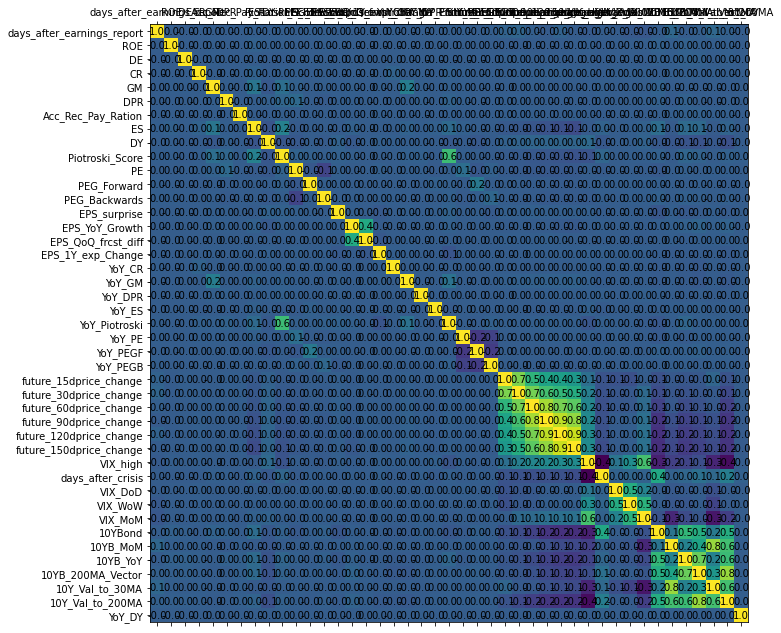

In [255]:
def plot_corr(df, size=11, method_cor = 'pearson'):
    corr = df.corr(method = method_cor)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
plot_corr(df_compact)

As we see there is no singel variable that can predict the prices movements

We can check with the Spearman method.

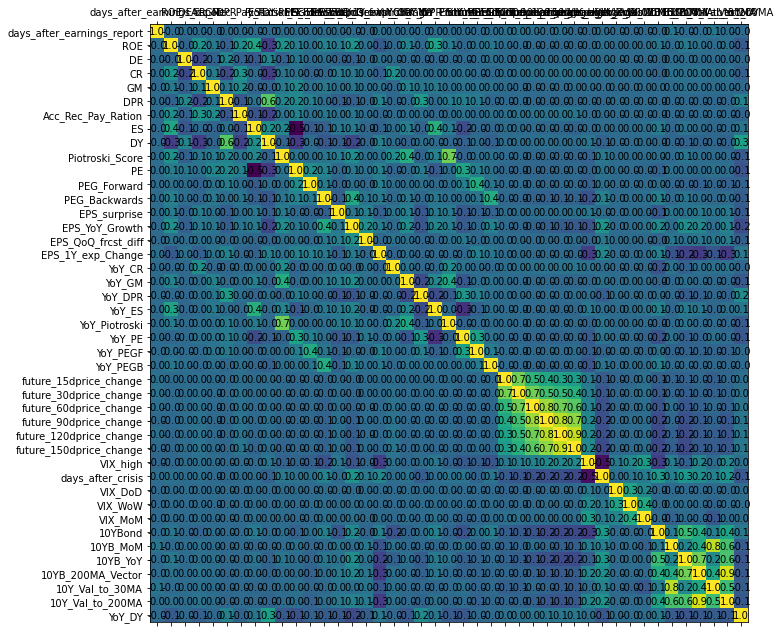

In [256]:
plot_corr(df_compact, size=11, method_cor = 'spearman')

We can see aslightly higher correlation between the variables but not with any of the targets

## Dealing with outliers

Before we change our dataset we need to split it by training and test data, so we keep the test data untouched

In [257]:
df_compact.sort_values('date', ascending = False, inplace = True)
display(df_compact.head(5))
display(df_compact.tail(5))

,date,days_after_earnings_report,sector,ROE,DE,CR,GM,DPR,Acc_Rec_Pay_Ration,ES,...,VIX_WoW,VIX_MoM,stock,10YBond,10YB_MoM,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,YoY_DY
0,2022-12-22,31.0,Health Care,0.034941,0.356692,2.030091,0.547323,0.168478,2.422414,0.804441,...,2.661597,0.746269,A,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,4.816762
82604,2022-12-22,49.0,Health Care,0.040029,0.011571,2.100338,0.658385,0.001422,8.548485,1.215107,...,2.661597,0.746269,MRNA,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,23.565522
15333,2022-12-22,42.0,Health Care,-0.025432,0.363862,1042.248112,0.436043,-0.602366,1289.582107,-1.847792,...,2.661597,0.746269,BDX,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,197.028886
75646,2022-12-22,56.0,Information Technology,0.066442,0.629777,1.248367,0.759903,0.189676,5.149593,0.755918,...,2.661597,0.746269,MA,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,27.381811
15014,2022-12-22,36.0,Consumer Discretionary,0.017728,-5.350691,1.341598,0.422693,0.505495,0.382911,0.985077,...,2.661597,0.746269,BBWI,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,80.856517


,date,days_after_earnings_report,sector,ROE,DE,CR,GM,DPR,Acc_Rec_Pay_Ration,ES,...,VIX_WoW,VIX_MoM,stock,10YBond,10YB_MoM,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,YoY_DY
66881,2016-10-13,76.0,Industrials,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.989702,...,29.696532,-5.376911,JCI,1.738,0.230681,-12.310797,-0.052981,3.899118,4.482739,97.060398
66882,2016-10-06,69.0,Industrials,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.942874,...,-11.790950,7.037896,JCI,1.742,12.896954,-15.436893,-0.040513,5.411405,4.393226,98.191213
66883,2016-09-29,62.0,Industrials,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.937533,...,17.176998,8.731809,JCI,1.556,-0.891720,-24.466019,-0.125552,-4.832905,-7.615360,117.785280
66884,2016-09-22,55.0,Industrials,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.957344,...,-25.899281,2.841782,JCI,1.632,5.086929,-23.880597,-0.073181,-0.042892,-3.330576,138.288908
66885,2016-09-15,48.0,Industrials,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.972044,...,43.412698,48.479869,JCI,1.703,8.058376,-26.052974,-0.015955,5.748679,0.647387,109.690527


In [258]:
#dropping date as abundant variable
#df_compact.drop('date',axis = 1, inplace = True)

In [259]:
#Let's reset index to understand the earliest and the latest records
df_compact.reset_index(inplace = True)
df_compact.drop('index', axis = 1, inplace = True)

In [642]:
df_compact_reserve = df_compact.copy()
display(df_compact.head(5))

,date,days_after_earnings_report,sector,ROE,DE,CR,GM,DPR,Acc_Rec_Pay_Ration,ES,...,VIX_WoW,VIX_MoM,stock,10YBond,10YB_MoM,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,YoY_DY
0,2022-12-22,31.0,Health Care,0.034941,0.356692,2.030091,0.547323,0.168478,2.422414,0.804441,...,2.661597,0.746269,A,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,4.816762
1,2022-12-22,49.0,Health Care,0.040029,0.011571,2.100338,0.658385,0.001422,8.548485,1.215107,...,2.661597,0.746269,MRNA,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,23.565522
2,2022-12-22,42.0,Health Care,-0.025432,0.363862,1042.248112,0.436043,-0.602366,1289.582107,-1.847792,...,2.661597,0.746269,BDX,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,197.028886
3,2022-12-22,56.0,Information Technology,0.066442,0.629777,1.248367,0.759903,0.189676,5.149593,0.755918,...,2.661597,0.746269,MA,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,27.381811
4,2022-12-22,36.0,Consumer Discretionary,0.017728,-5.350691,1.341598,0.422693,0.505495,0.382911,0.985077,...,2.661597,0.746269,BBWI,3.686,-1.915913,153.647124,0.110135,2.733587,7.647396,80.856517


In [219]:
#df_train, df_test = train_test_split(df_compact, test_size=0.1, random_state=42)

Train data size is 116769 rows
Train data size is 6591 rows
We used latest 6591 rows as a test data


In [518]:
#Let's take the top 5% as the test df
y_vals = ["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
n_days = [15,30,60,90,120,150]

test_dfs_list = []
train_dfs_list = []

for i, j in enumerate(y_vals):
    n = 5
    num_rows = int(len(df_compact[df_compact[j].notnull()])*(n/100))
    df_test = df_compact[df_compact[j].notnull()].iloc[:num_rows]
    df_train = df_compact[df_compact[j].notnull()].iloc[num_rows:]
    
    #Let's remove the data closest to the prediction date to make it close to a real world scenario
    max_date = df_train.date.max()
    max_date = datetime.strptime((df_train.date.max()), '%Y-%m-%d') - timedelta(days=n_days[i])
    max_date = max_date.strftime('%Y-%m-%d')
    df_train = df_train[df_train.date < max_date]
    
    #We can drop the date column as redundant now
    df_train.drop('date',axis = 1, inplace = True)
    df_test.drop('date',axis = 1, inplace = True)
    
    test_dfs_list.append(df_test)
    train_dfs_list.append(df_train)
    
    
    print(f"Train data size for {n_days[i]} is {df_train.shape[0]} rows")
    print(f"Test data size for {n_days[i]}  is {df_test.shape[0]} rows")

Train data size for 15 is 123290 rows
Test data size for 15  is 6541 rows
Train data size for 30 is 121294 rows
Test data size for 30  is 6491 rows
Train data size for 60 is 117847 rows
Test data size for 60  is 6391 rows
Train data size for 90 is 113862 rows
Test data size for 90  is 6291 rows
Train data size for 120 is 110087 rows
Test data size for 120  is 6191 rows
Train data size for 150 is 106271 rows
Test data size for 150  is 6091 rows


In [519]:
#For the simplicity of analysis we will work with one train dataframe but apply transformations to all the dataframes in the list
df_train = train_dfs_list[0]

cols_num = df_train.select_dtypes([np.number]).columns
cols_str = df_train.select_dtypes('object').columns

df_train[cols_num].describe().T

,count,mean,std,min,25%,50%,75%,max
days_after_earnings_report,123290.0,45.461538,2.724887e+01,0.000000e+00,22.000000,45.000000,69.000000,1.620000e+02
ROE,123290.0,17.660850,6.185437e+03,-3.414091e-01,0.005692,0.014378,0.027353,2.171872e+06
DE,123290.0,40.659488,3.634062e+03,-2.298046e+02,0.201972,0.426149,0.709969,3.294849e+05
CR,123290.0,1661.196359,1.127368e+05,-1.272126e+02,0.946298,1.389677,2.250575,9.490595e+06
GM,123290.0,0.435916,1.216813e+00,-6.379194e+01,0.292646,0.437164,0.640647,1.446465e+01
DPR,123290.0,0.271631,3.061457e+01,-2.410406e+03,0.069832,0.301113,0.569305,6.023810e+02
Acc_Rec_Pay_Ration,123290.0,201.523774,1.911075e+04,0.000000e+00,0.848052,1.635922,3.124134,2.099573e+06
ES,123290.0,0.954329,3.479821e+00,-1.120826e+02,0.574660,1.041167,1.677460,5.924357e+01
DY,123290.0,2.357909,3.388145e+00,0.000000e+00,0.766664,1.835584,3.027102,1.238991e+02
Piotroski_Score,123290.0,6.373729,1.335437e+00,1.000000e+00,6.000000,6.000000,7.000000,9.000000e+00


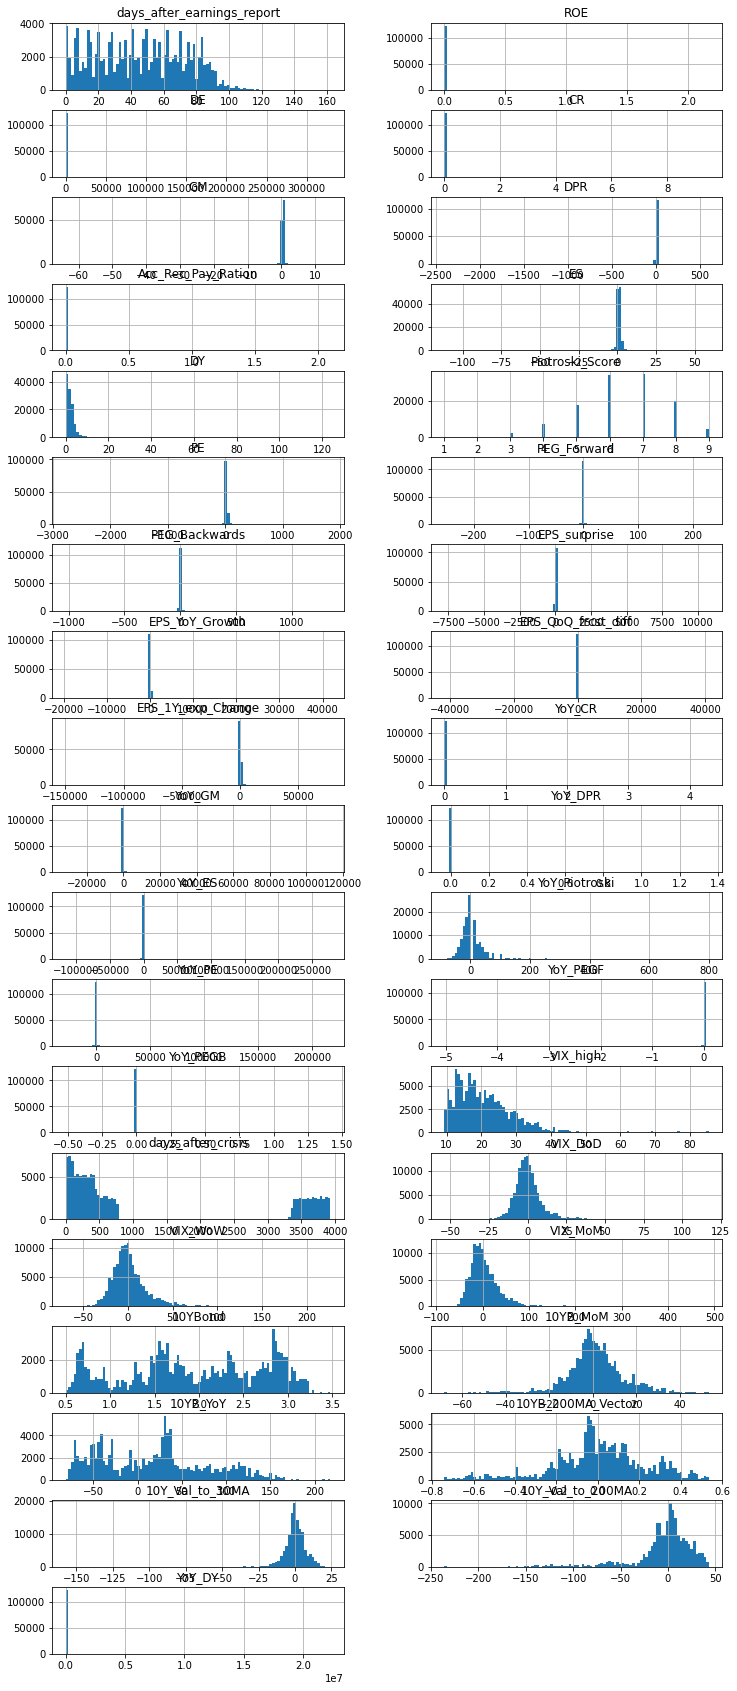

In [520]:
target_vars = ["future_15dprice_change", "future_30dprice_change", "future_60dprice_change", "future_90dprice_change", "future_120dprice_change", "future_150dprice_change"]
cols_num_no_targets = [x for x in cols_num if x not in target_vars]
df_train[cols_num_no_targets].hist(stacked=False, bins=100, figsize=(12,30), layout=(19,2));

#### There are many outliers we would need to treat.

#### Let's replace outliers with 3 st.dev values to normalize our data a little

 Now we need to select columns that we want to "treat".
 We need only columns with wide values distribution that looks like a normal distribution:

In [522]:
columns_to_trim = ['ROE',
                     'DE',
                     'CR',
                     'GM',
                     'DPR',
                     'Acc_Rec_Pay_Ration',
                     'ES',
                     'DY',
                     'PE',
                     'PEG_Forward',
                     'PEG_Backwards',
                     'EPS_surprise',
                     'EPS_YoY_Growth',
                     'EPS_QoQ_frcst_diff',
                     'EPS_1Y_exp_Change',
                     'YoY_CR',
                     'YoY_GM',
                     'YoY_DPR',
                     'YoY_ES',
                     'YoY_Piotroski',
                     'YoY_PE',
                     'YoY_PEGF',
                     'YoY_PEGB',
                    '10Y_Val_to_30MA',
                     '10Y_Val_to_200MA',
                     'YoY_DY'  ]

In [523]:
def replace_train(group):
    mean, std = group.mean(), group.std()
    outliers_max = (group - mean) > 3*std
    outliers_min = (mean - group) > 3*std
    #outliers = (group - mean).abs() > 3*std
    group[outliers_max] = mean + 3*std    
    group[outliers_min] = mean - 3*std    
    return group

for dataframe in train_dfs_list:
    dataframe[columns_to_trim] = dataframe[columns_to_trim].transform(replace_train)

## Categorical Data

In [524]:
df_train = train_dfs_list[0]
df_train[["sector","stock"]].groupby("sector").nunique()

,stock
sector,
Communication Services,24
Consumer Discretionary,55
Consumer Staples,32
Energy,23
Financials,67
Health Care,63
Industrials,71
Information Technology,72
Materials,29


In [525]:
df_train.groupby("sector").mean().style.highlight_max(color='green').highlight_min(color='red')

,days_after_earnings_report,ROE,DE,CR,GM,DPR,Acc_Rec_Pay_Ration,ES,DY,Piotroski_Score,PE,PEG_Forward,PEG_Backwards,EPS_surprise,EPS_YoY_Growth,EPS_QoQ_frcst_diff,EPS_1Y_exp_Change,YoY_CR,YoY_GM,YoY_DPR,YoY_ES,YoY_Piotroski,YoY_PE,YoY_PEGF,YoY_PEGB,future_15dprice_change,future_30dprice_change,future_60dprice_change,future_90dprice_change,future_120dprice_change,future_150dprice_change,VIX_high,days_after_crisis,VIX_DoD,VIX_WoW,VIX_MoM,10YBond,10YB_MoM,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,YoY_DY
sector,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Communication Services,45.356718,0.016224,0.435204,1.884296,0.487292,0.748879,3.641594,1.147560,2.795922,6.229996,30.915962,0.055053,0.316048,18.590084,21.132961,0.226604,100.277725,1.990998,-1.313305,116.622480,80.763416,3.444296,12.023584,204.343766,42.544883,0.249111,0.474814,0.772910,1.051106,1.427473,1.895761,21.556533,1229.298102,0.290908,2.128742,7.429371,1.930449,1.341380,17.377122,0.004190,-0.002564,-4.031802,490.820219
Consumer Discretionary,45.742017,0.021247,1.450616,2.076212,0.326202,0.177151,1.160482,0.896007,1.707151,6.196662,22.447782,0.011804,0.370619,10.494800,8.968302,0.097557,226.456764,6.961215,2.755310,1332.684047,10.983942,5.343129,-5.545540,103.961572,-133.952237,0.396150,0.784969,1.403172,1.924172,2.570937,3.195979,21.172962,1324.885631,0.547379,2.072402,7.153501,1.954368,1.050427,15.758418,-0.000669,-0.187706,-4.550393,6694.149983
Consumer Staples,45.542150,0.022655,0.831811,1.347983,0.403683,0.424080,0.889556,1.130764,2.636675,6.386605,22.123370,0.230258,1.509688,7.284703,2.769877,-0.006712,234.292421,12.346129,-0.020783,-520.999113,-20.673207,3.923698,2.195873,2.879070,-93.190433,0.327485,0.625521,1.123215,1.625134,2.248640,2.801606,21.109745,1333.686593,0.417034,2.148226,7.224166,1.958283,1.110434,16.085061,0.000151,-0.100134,-4.400281,551.974717
Energy,45.629373,0.003664,0.544102,1.270571,0.271853,0.495661,1.710306,0.237144,3.684080,6.408098,18.317892,0.071335,0.337625,11.015134,12.056624,-0.533393,47.923239,1.082329,-10.512313,173.845523,-25.156117,13.537204,-63.730759,29.449295,-247.951198,0.859795,1.807389,3.406792,4.966114,6.431106,7.622918,21.363179,1268.207423,0.406537,2.154893,7.586003,1.964153,1.444268,19.108098,0.009665,0.033134,-3.327267,717.579231
Financials,45.029367,1.275087,0.274079,913.086166,0.664109,0.332200,16.121854,1.876974,2.446991,6.324447,16.734185,-0.008905,0.617820,8.131481,21.624159,1.165810,177.197799,166530.476736,12.046565,442.466073,-2.811405,4.368038,15.702147,-27.061909,-121.531230,0.559376,1.043599,1.876213,2.763943,3.768374,4.666527,21.313080,1304.073564,0.443607,2.193381,7.901766,1.962177,1.305405,17.244121,0.004589,-0.044627,-3.903664,101.302012
Health Care,45.564722,0.020998,0.587703,2.220757,0.528856,0.467390,3.638471,0.956456,1.219148,6.412600,23.726399,0.062075,1.075276,9.219666,4.626072,-0.488454,127.077232,57.036593,3.833819,273.423104,7.444040,5.432351,3.572251,-7.999136,-59.720534,0.708977,1.315376,2.421959,3.595034,4.808746,6.076459,21.305561,1303.428080,0.429812,2.134154,7.613424,1.960289,1.317830,17.048486,0.004137,-0.061217,-4.011801,282.566057
Industrials,45.349489,0.021516,0.301834,1.771316,0.327707,0.343032,36.415681,1.044036,1.863919,6.402009,22.265018,0.031073,0.858063,8.794407,5.218789,-0.613306,184.738500,5.300550,-8.968098,968.000577,-11.417785,4.572583,8.844615,5.823321,2.127167,0.652641,1.200883,2.162125,3.217955,4.359649,5.400872,21.468317,1279.528401,0.516552,2.186790,7.984615,1.951267,1.486285,18.382404,0.007711,0.007748,-3.700027,1768.471994
Information Technology,45.302028,0.049020,9.032438,2.128175,0.550436,1.098538,6.642089,0.840342,1.672874,6.549901,28.968414,0.089640,0.749502,10.381964,15.849805,-0.131366,227.127531,0.918684,2.736229,2.647076,1.412542,4.850482,12.228852,95.390337,-22.928868,0.800218,1.514691,2.728289,3.953949,5.267499,6.630129,21.219565,1320.010542,0.487975,2.174472,7.672345,1.964239,1.243469,16.878818,0.003601,-0.078653,-4.056588,3587.814200
Materials,

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


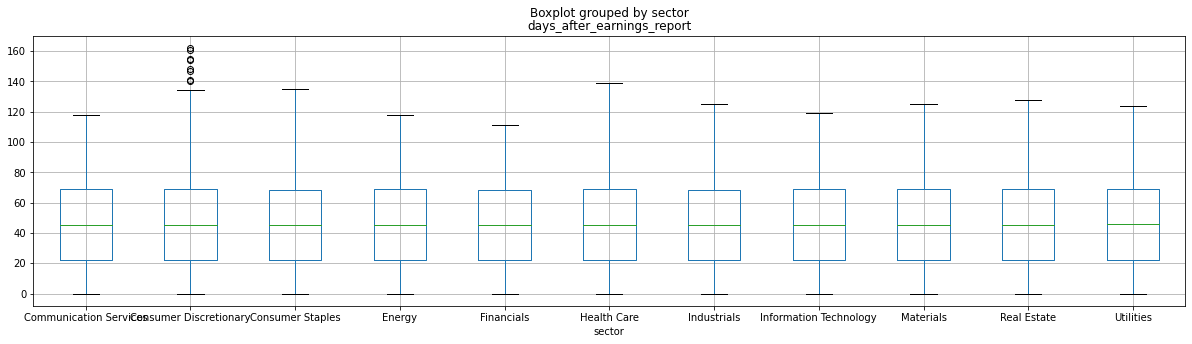

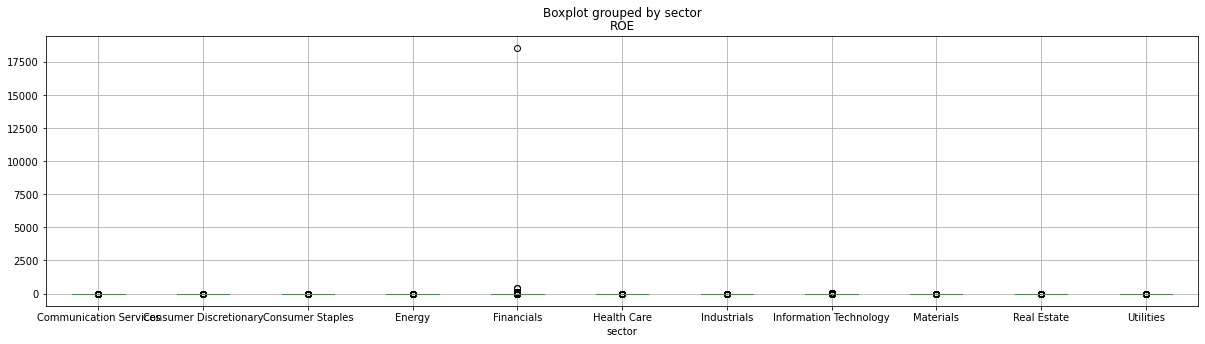

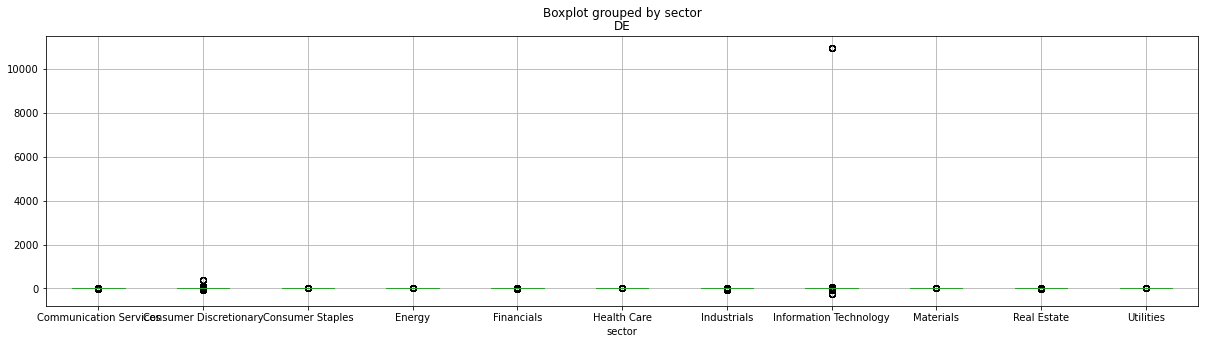

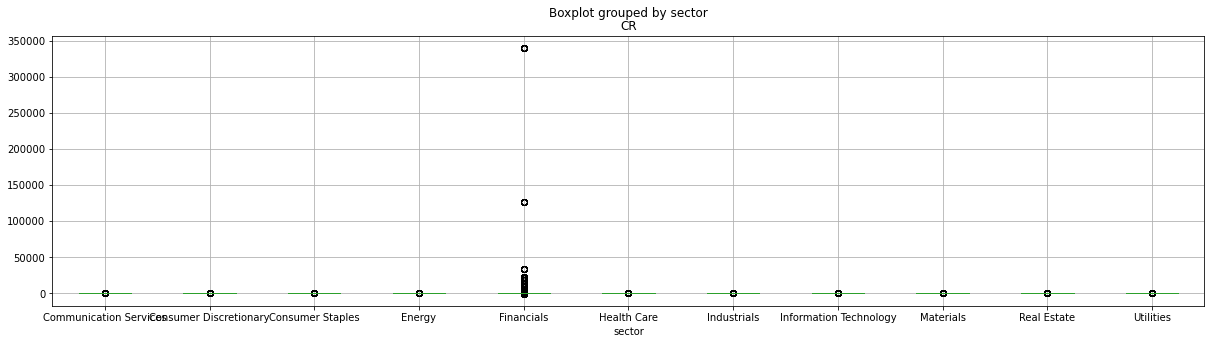

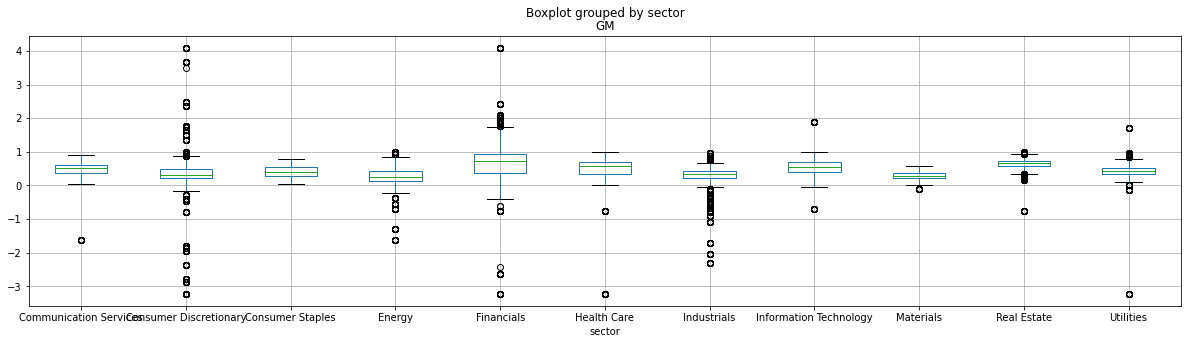

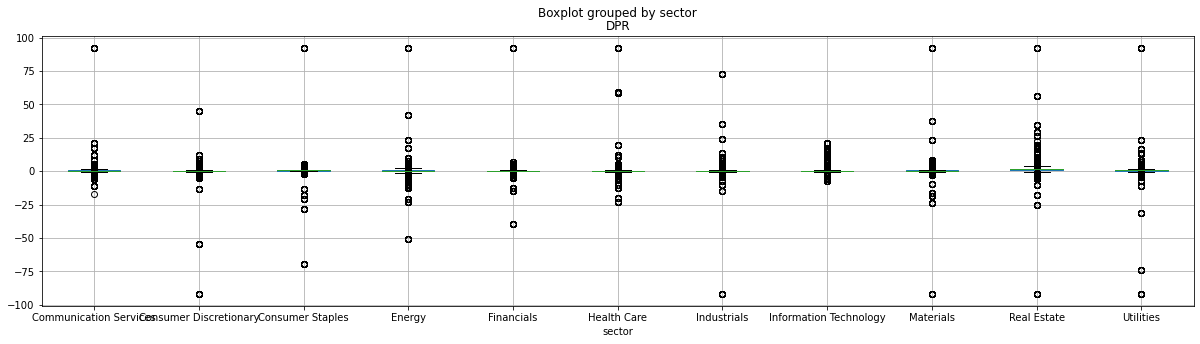

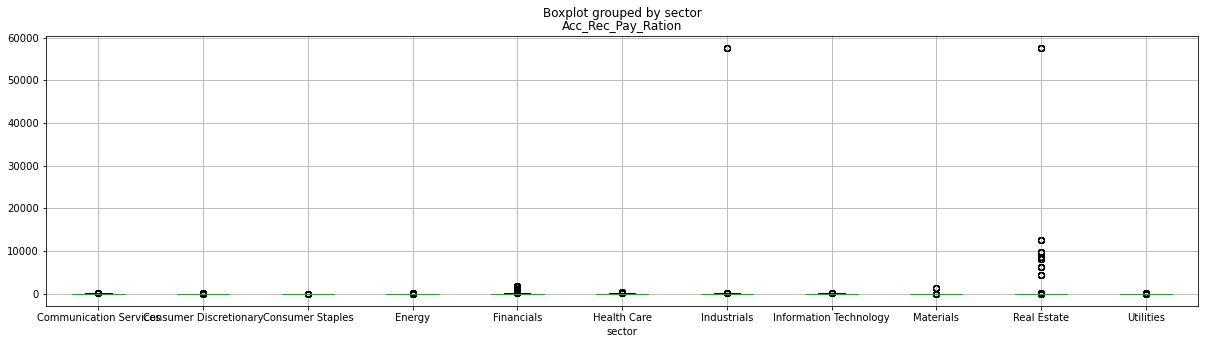

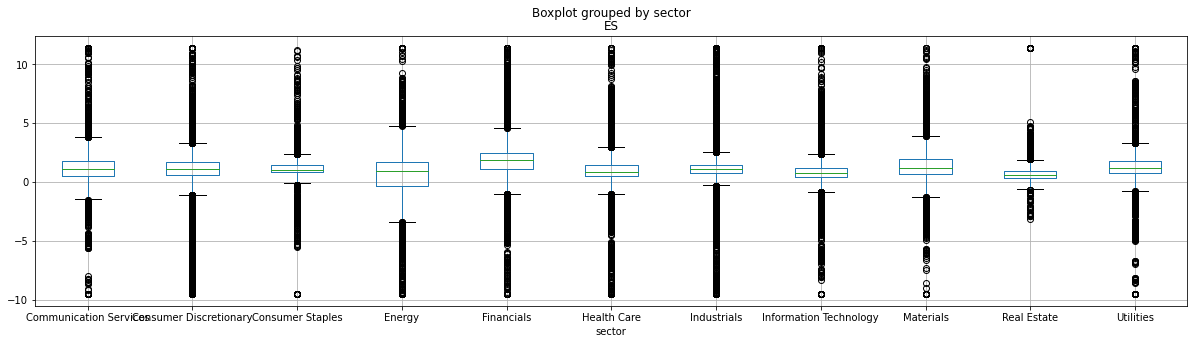

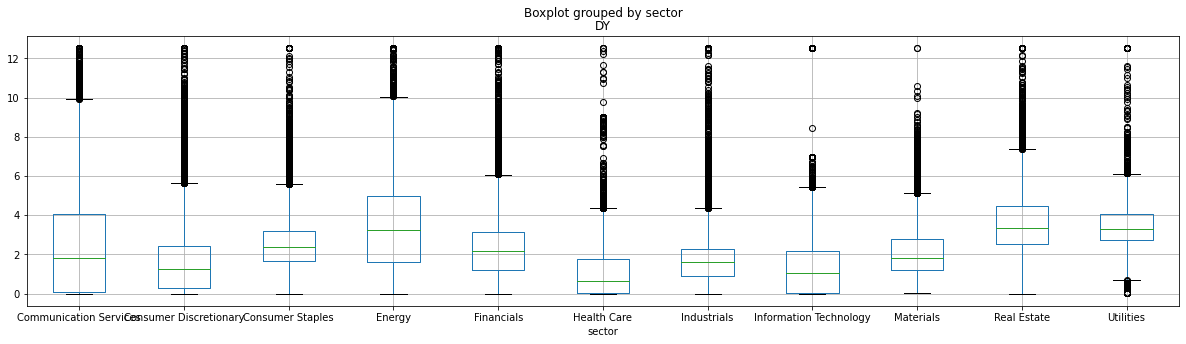

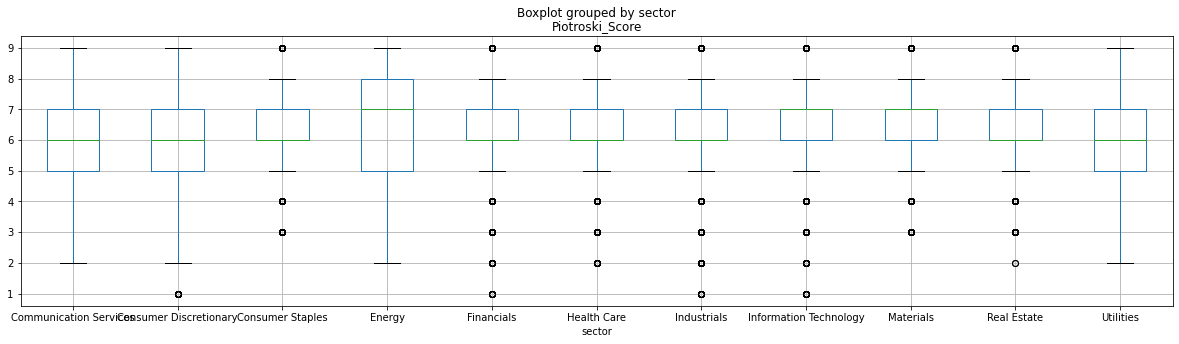

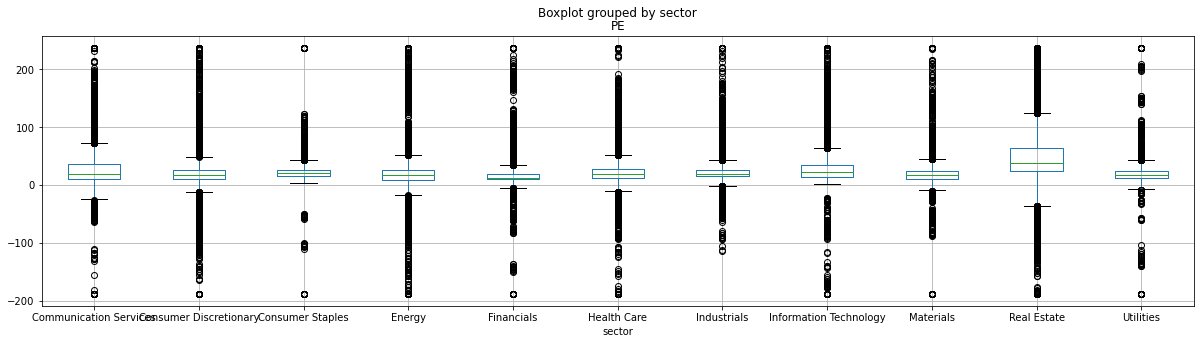

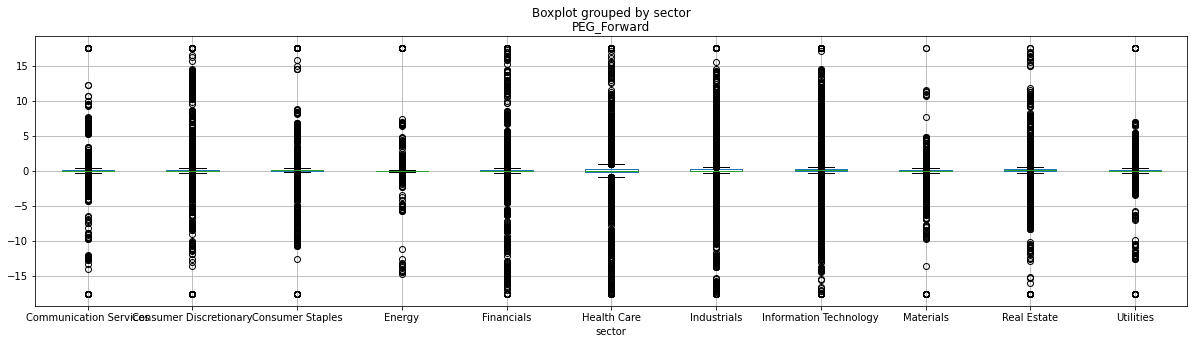

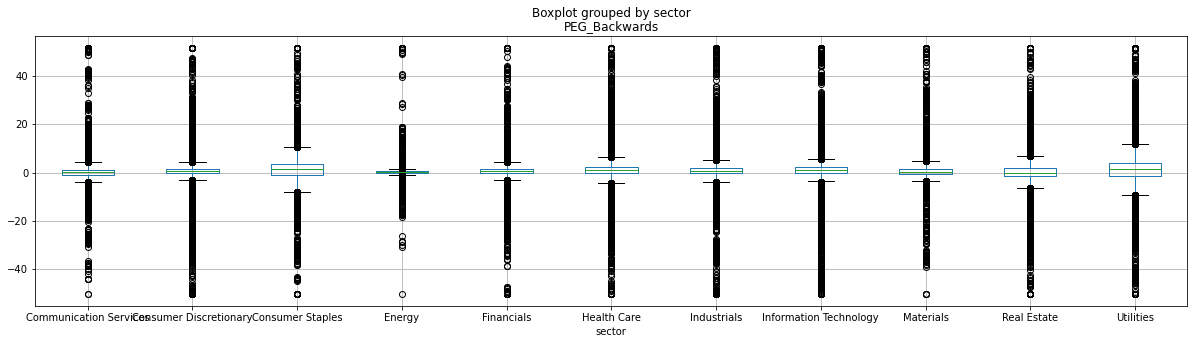

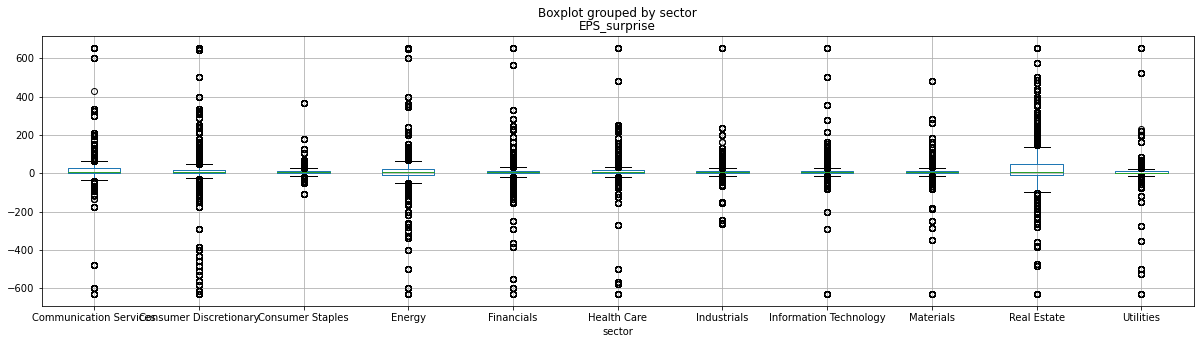

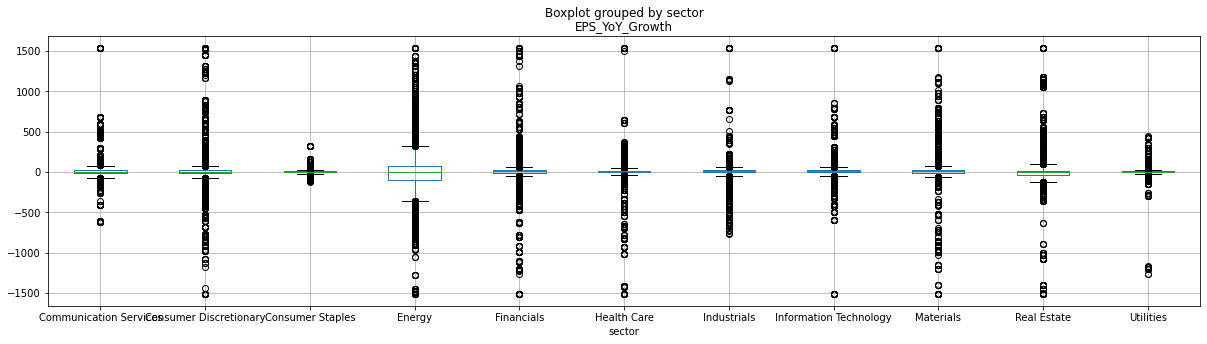

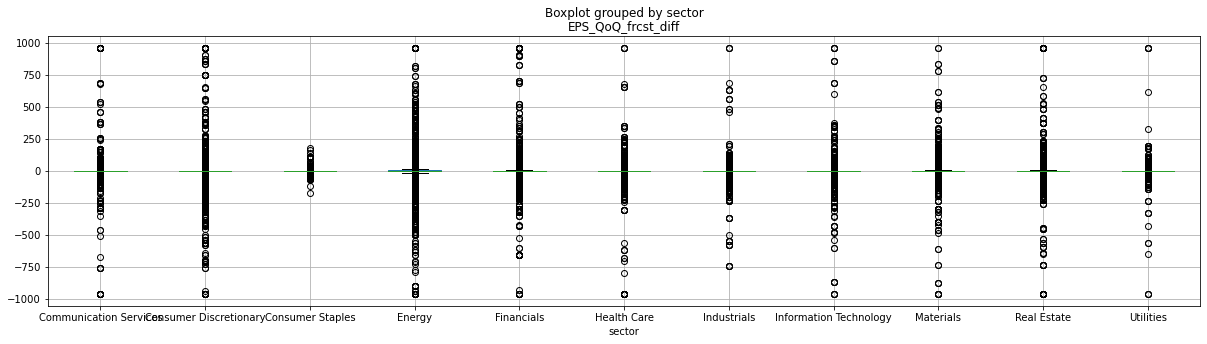

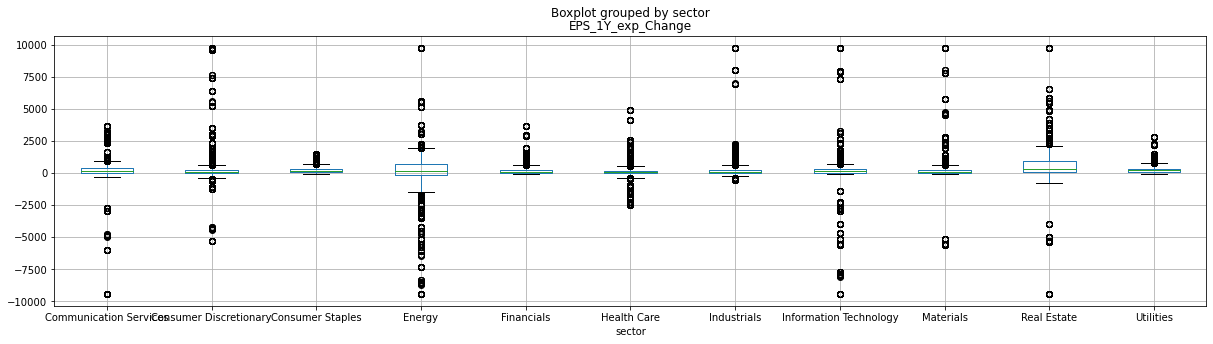

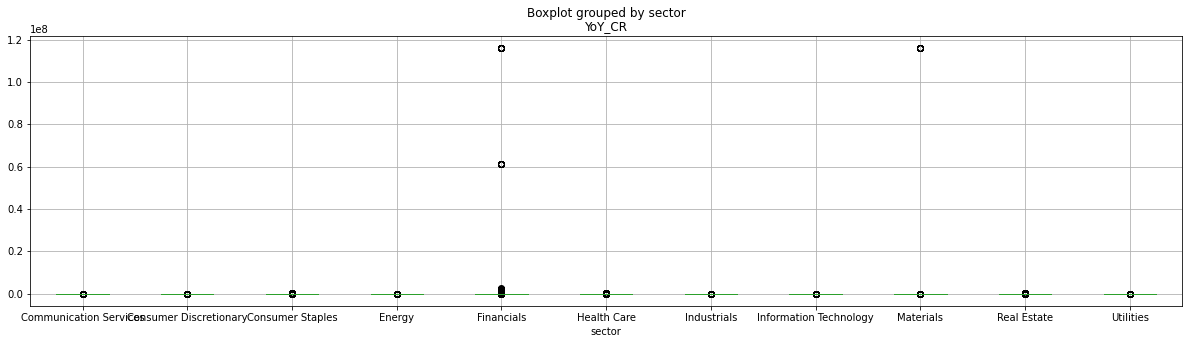

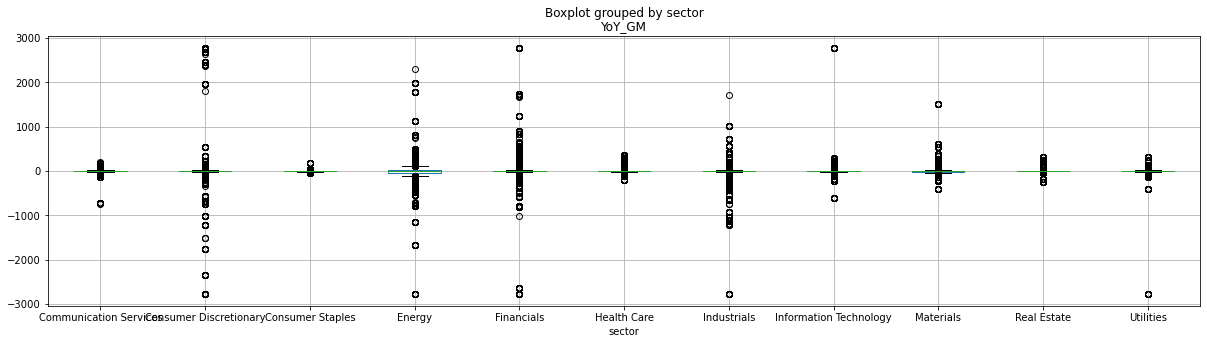

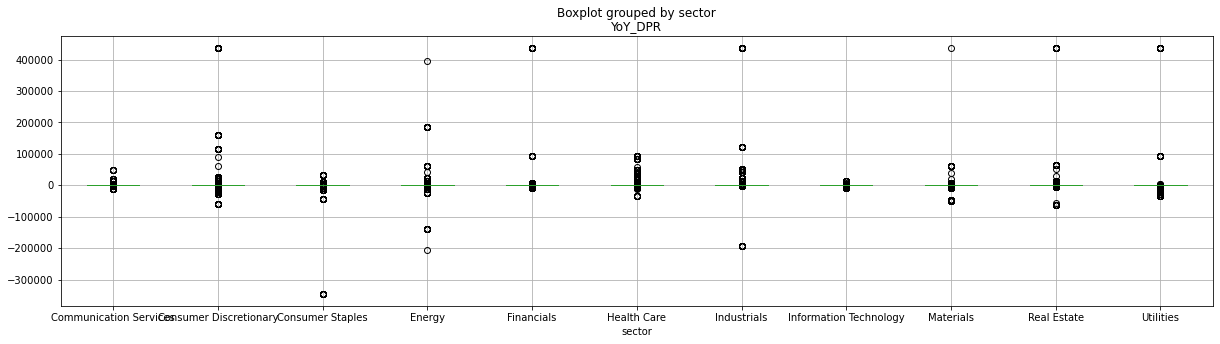

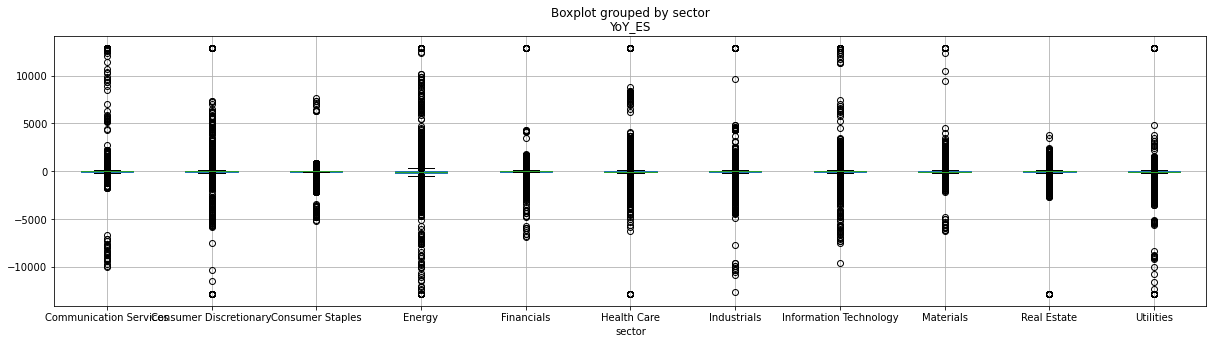

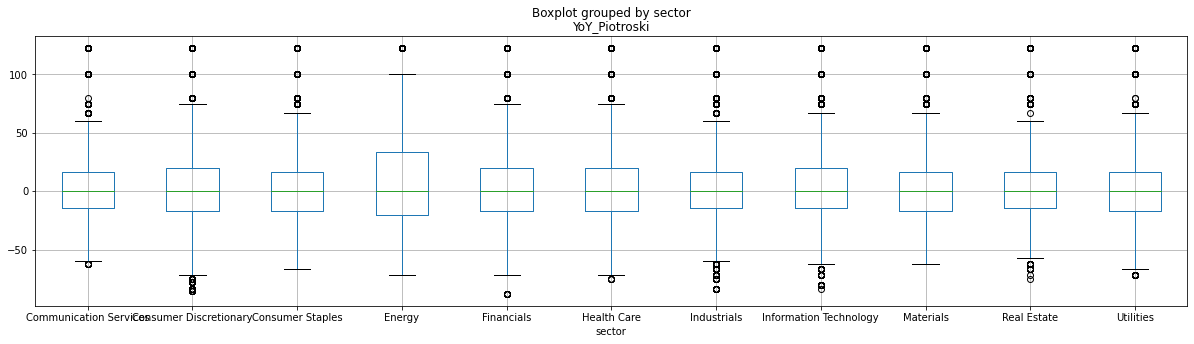

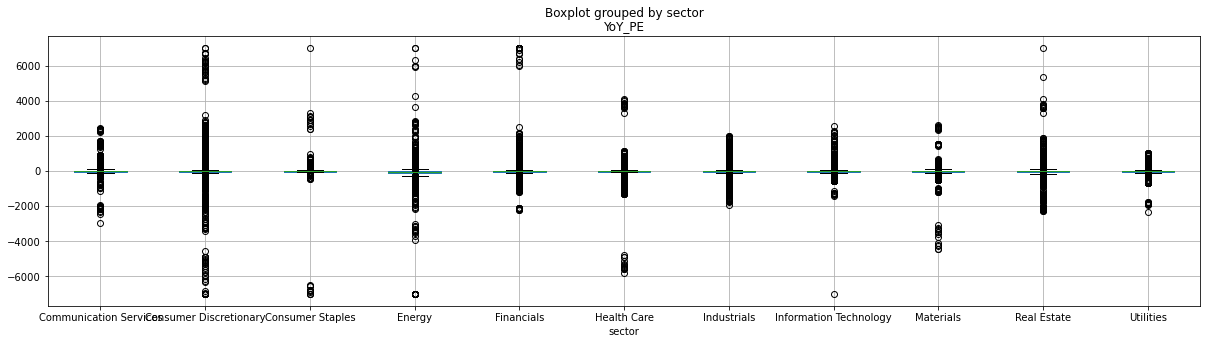

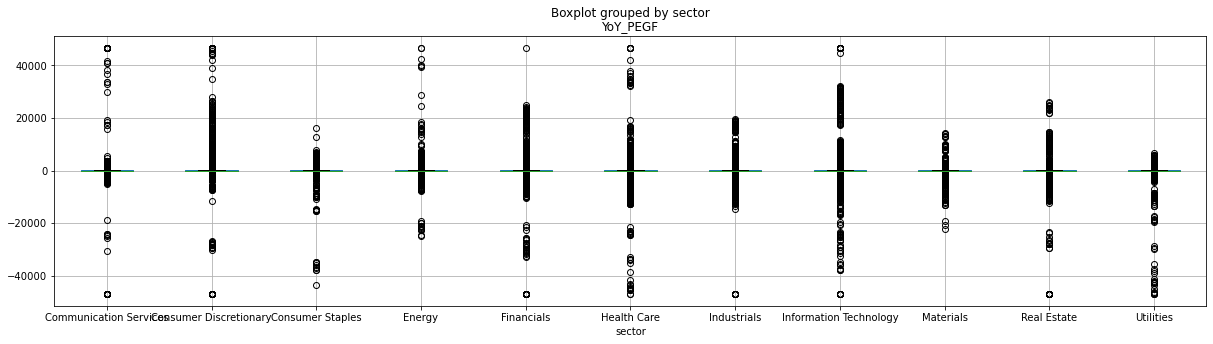

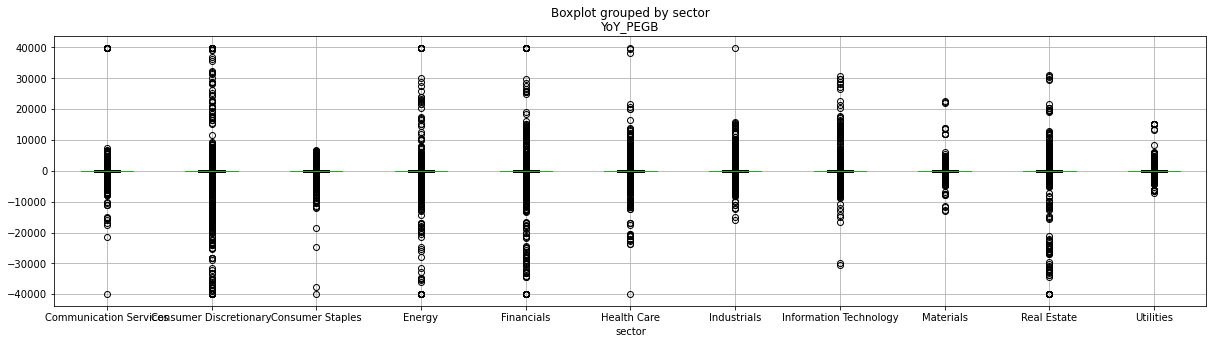

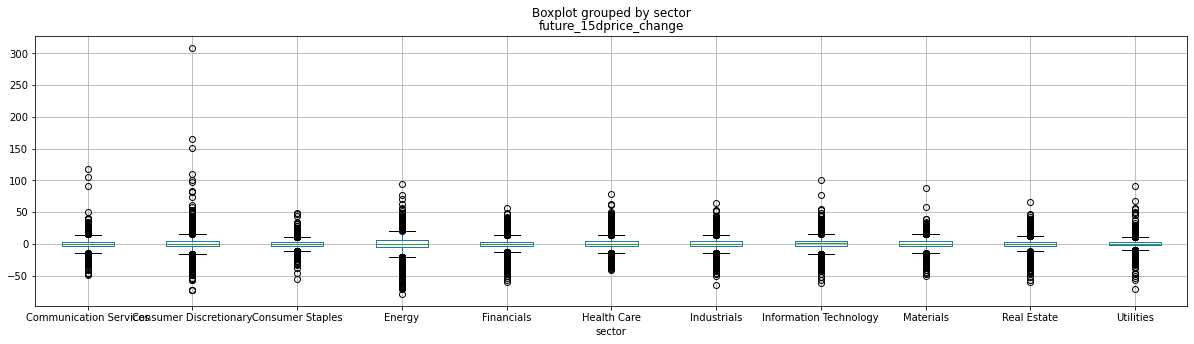

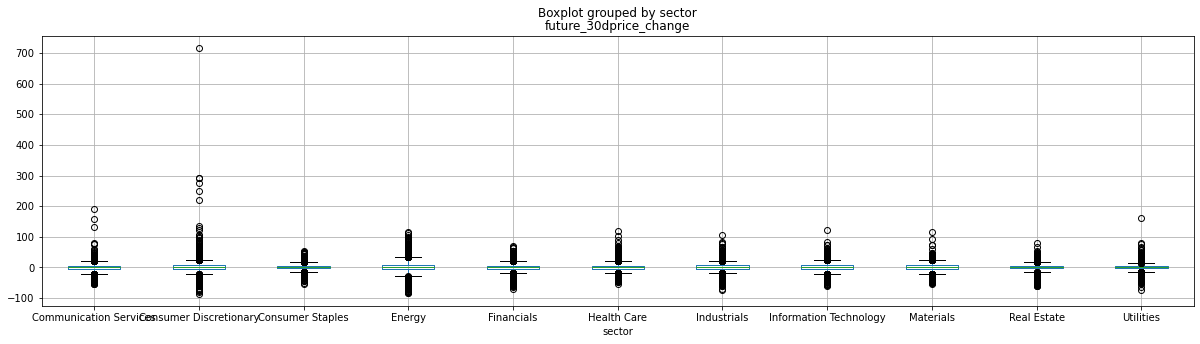

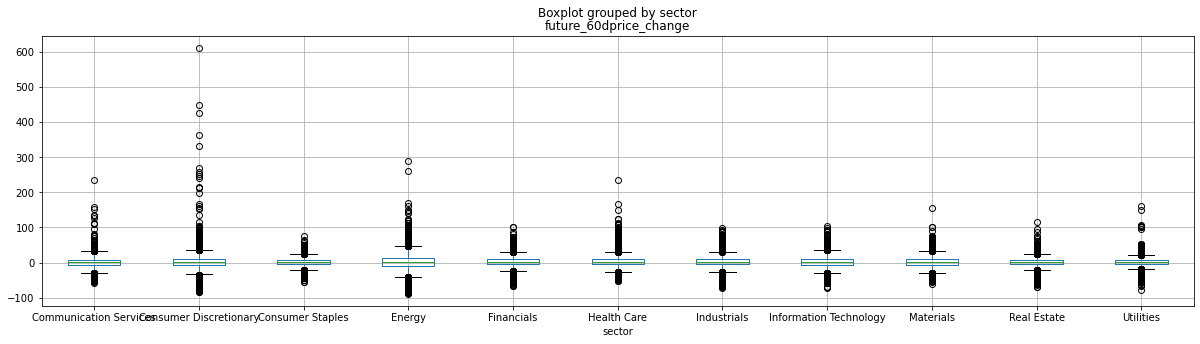

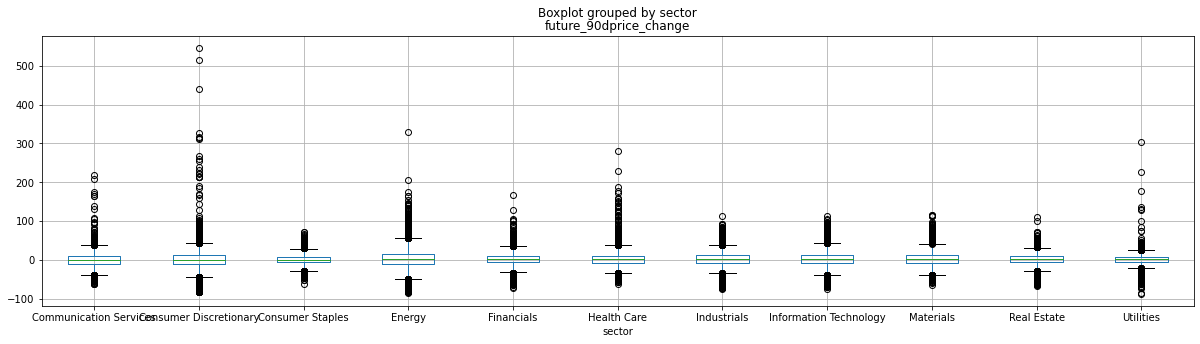

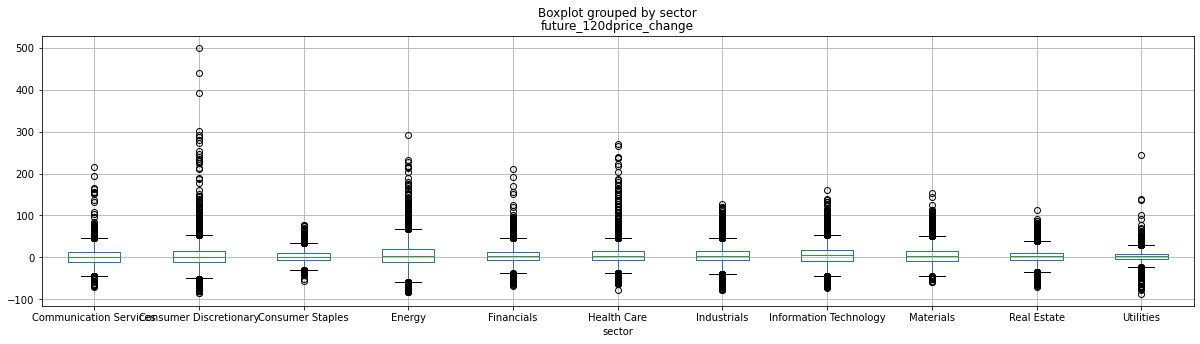

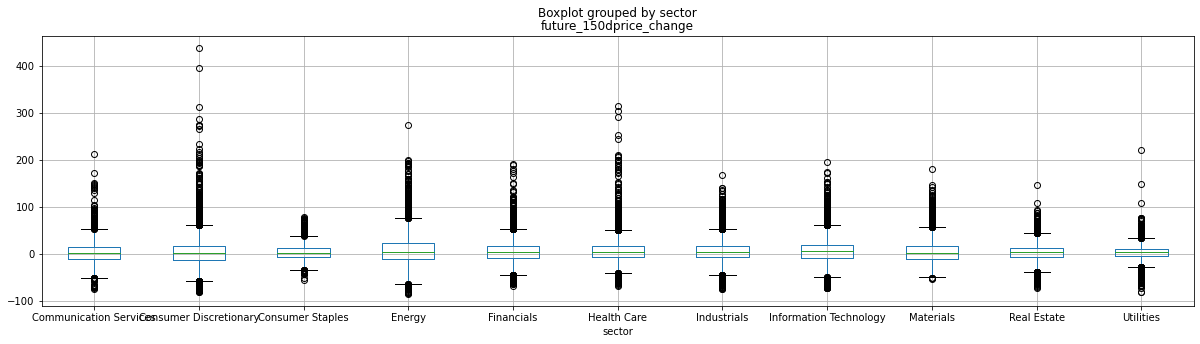

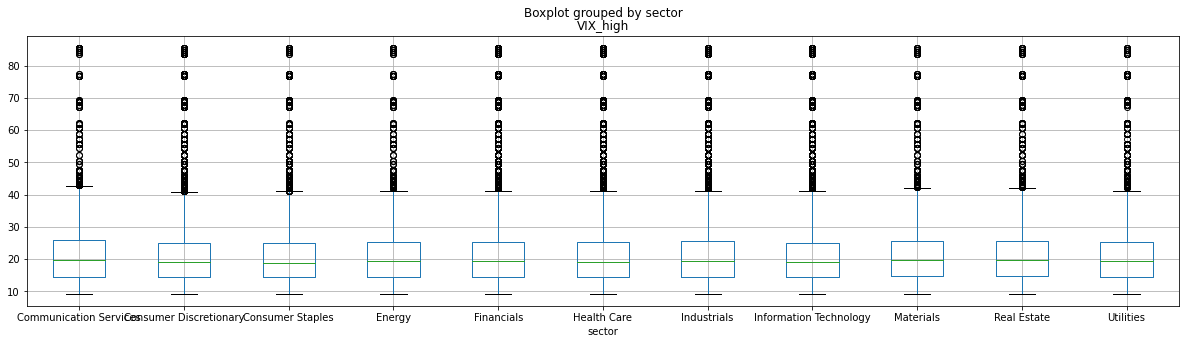

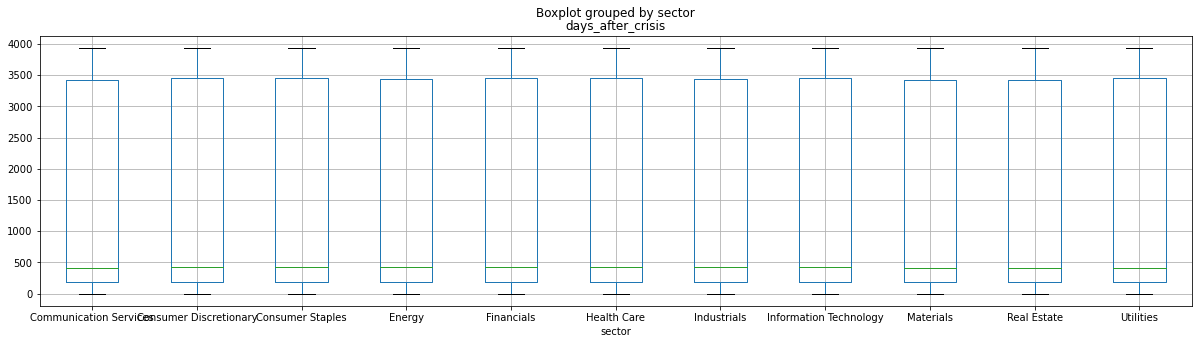

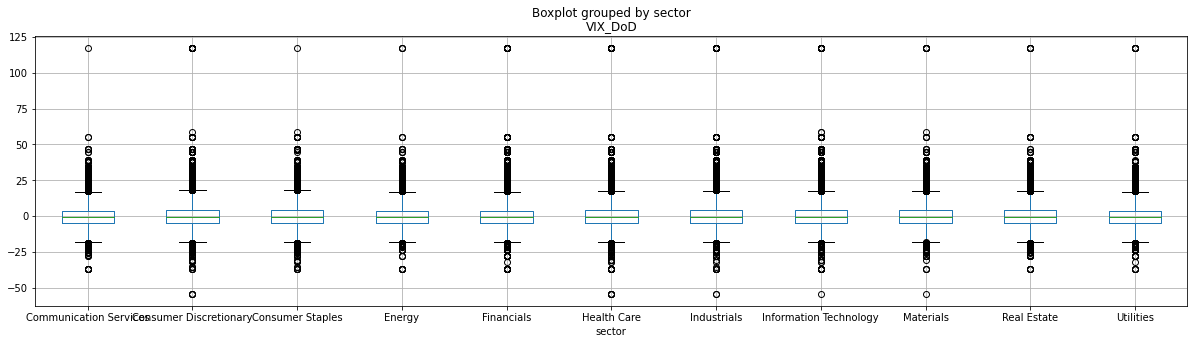

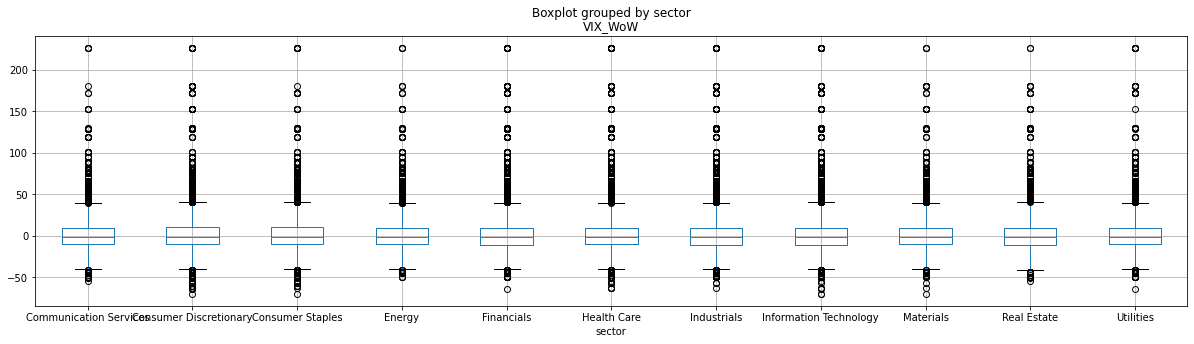

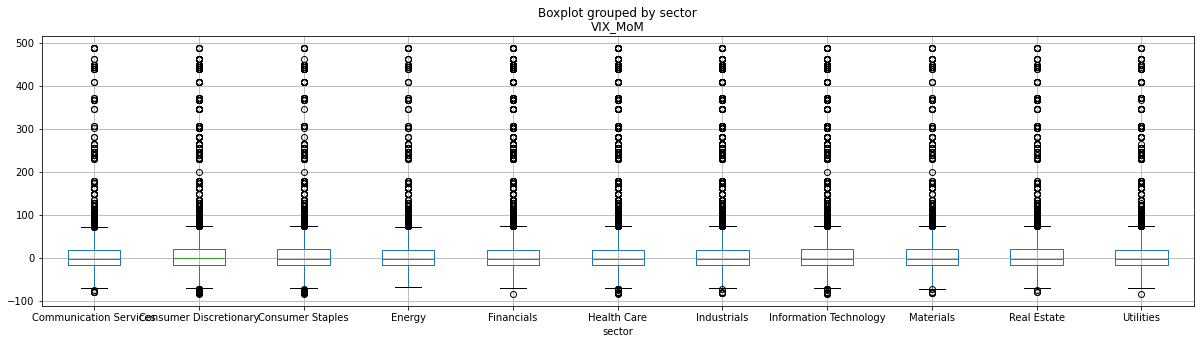

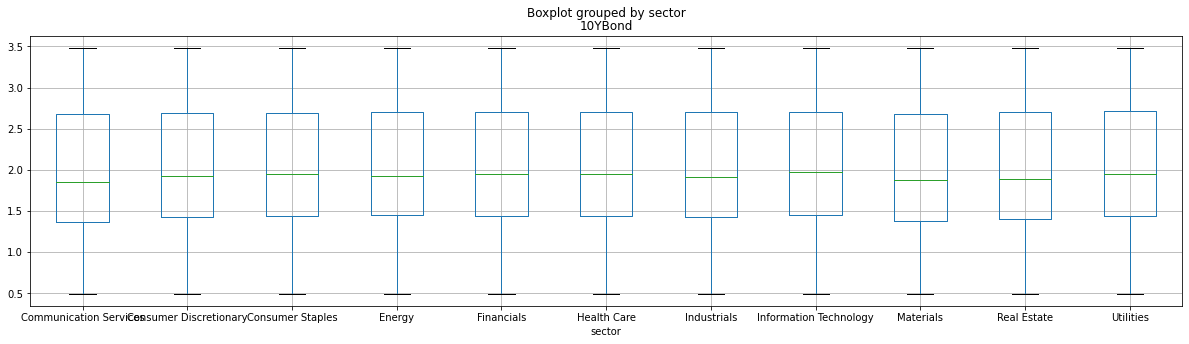

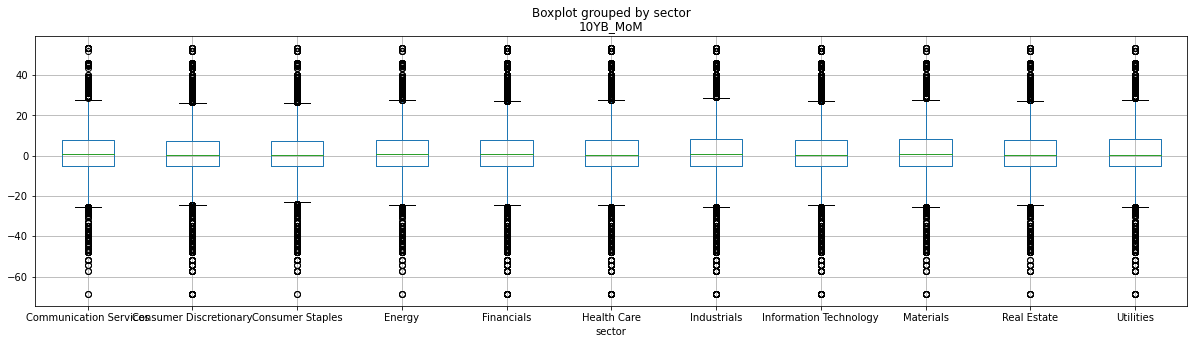

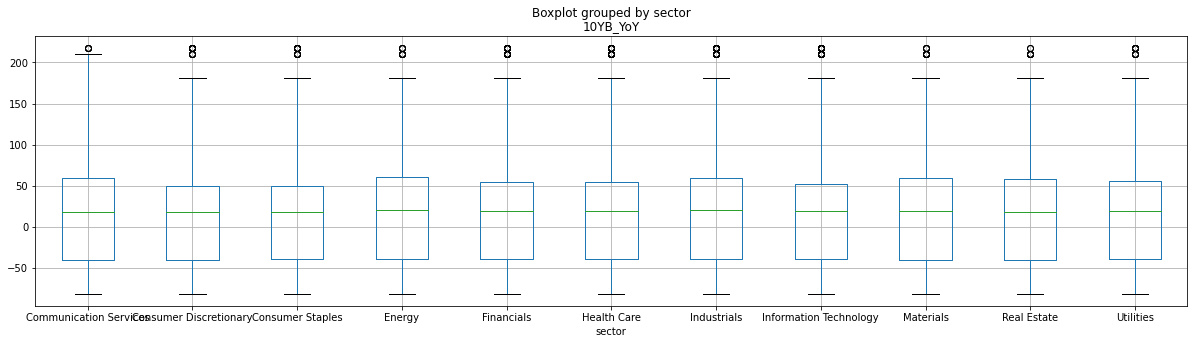

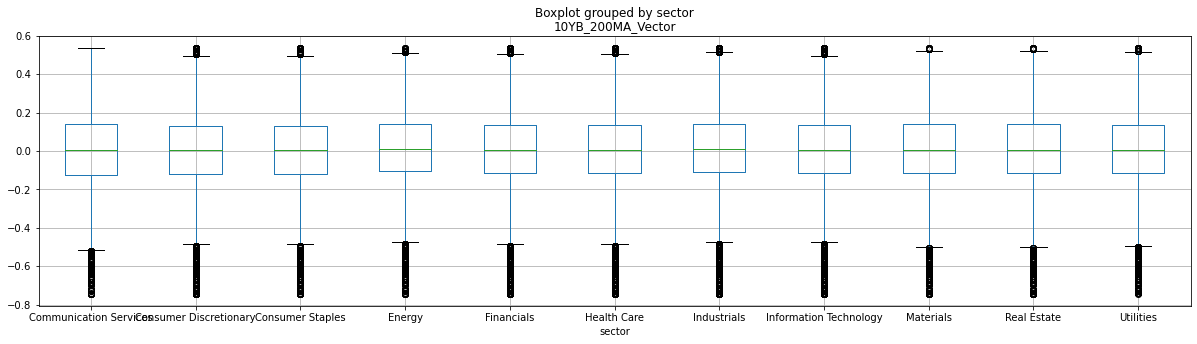

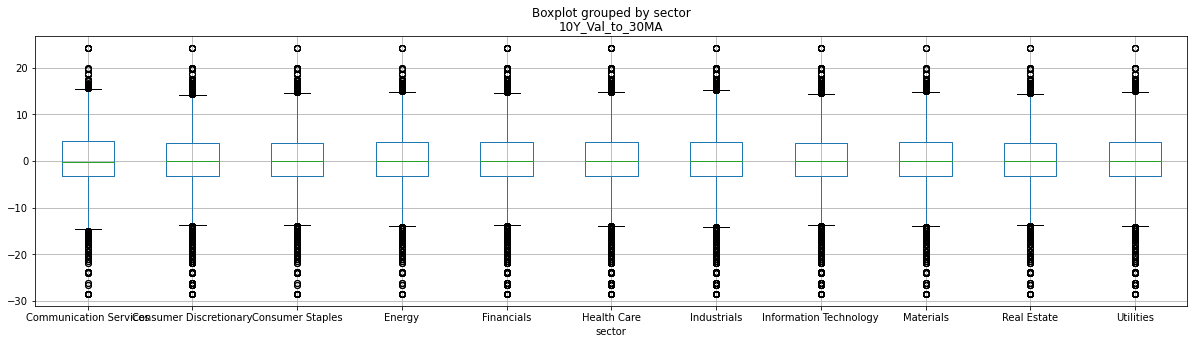

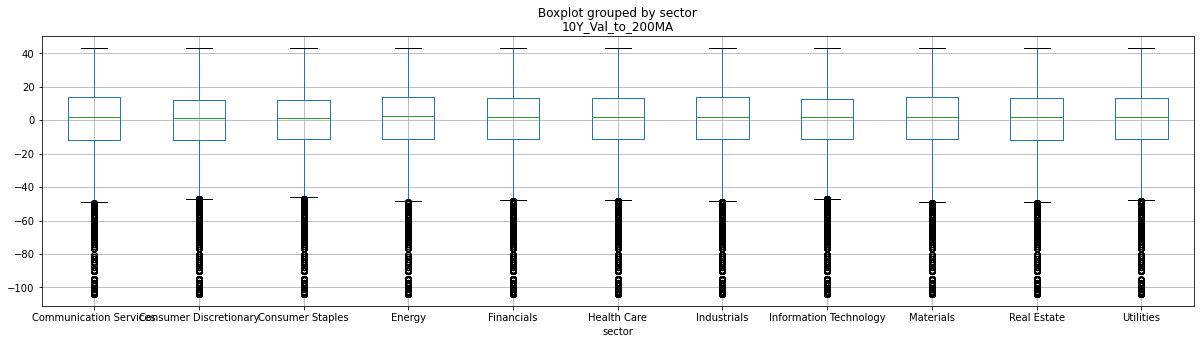

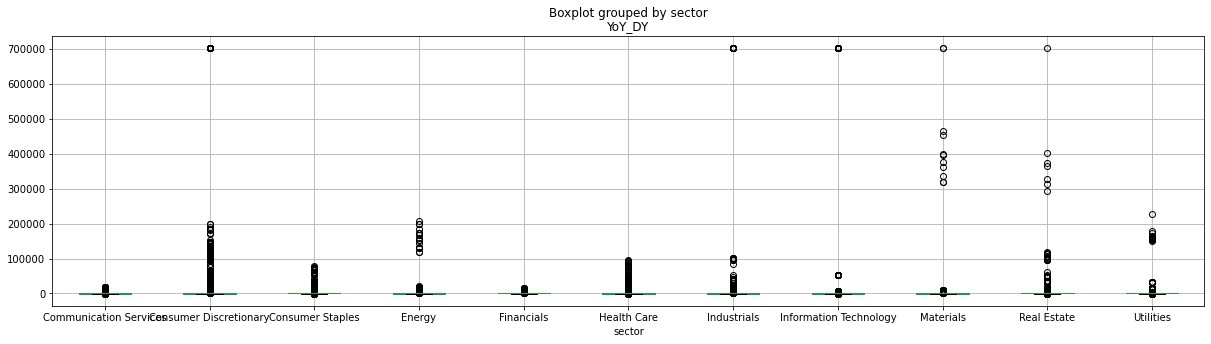

In [526]:
# First we need to select columns that we did not use in outliers replacement
numeric_columns = df_train.select_dtypes(include='number').columns

def create_box_plots(df, columns, by = None, height = 20, width = 10):
    fig, axes = plt.subplots(nrows=len(columns)//2, ncols=2, figsize = (height,width)) # create 2x2 array of subplots

    j = 0
    for col_num, col in enumerate(columns):
        if (col_num % 2) != 0:
            j+=1
        else:
            j = 0
        if by == None:
            df.boxplot(column=col, ax=axes[col_num //2 ,j], figsize = (3,10)); # add boxplot to 1st subplot
        else:
            df.boxplot(column=col, ax=axes[col_num //2 ,j], by = by, figsize = (3,10));

    plt.show()

#create_box_plots(df_train, numeric_columns, "sector", 20,60)
for col in numeric_columns:
    df_train.boxplot(column=col, by = "sector", figsize = (20,5))

We risk to loose about 1.5-2% of the data dealing with outliers. We can go ahead and remove outliers

 ## Let's check the data for skewness

We won't treat data for skeweness

# ML Part Regression

In [531]:
#df_compact_30 = df_compact.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
#df_train_gen , df_test_gen = df_train.copy(), df_test.copy()
df_train, df_test = train_dfs_list[0], test_dfs_list[0]

In [532]:
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_test = df_test.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)

In [533]:
#df_compact_30 = df_compact_30[df_compact_30['future_30dprice_change'].notna()]
df_train = df_train[df_train['future_30dprice_change'].notna()]
df_test = df_test[df_test['future_30dprice_change'].notna()]

In [534]:
#df_train, df_test = train_test_split(df_compact_30, test_size=0.2, random_state=42)

Light GBM can work with categoricl features 8x faster without using OneHotEncoder.
But transforming string to int is still required

In [535]:
le = LabelEncoder()
le.fit(df_train["sector"])


df_train["sector"] = le.transform(df_train["sector"])
df_test["sector"] = le.transform(df_test["sector"])

In [536]:
df_train.drop('stock', axis = 1, inplace = True)
df_test.drop('stock', axis = 1, inplace = True)

In [537]:
#Creating the x, y variables 
y_train = df_train['future_30dprice_change']
y_test = df_test['future_30dprice_change']

x_train = df_train.drop('future_30dprice_change', axis = 1)
x_test = df_test.drop('future_30dprice_change', axis = 1)

#Creating a model

In [538]:
lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(n_estimators=50, n_jobs=5, random_state=42)

In [539]:
#predicting on test set
ypred=lgbm.predict(x_test)

In [540]:
#calculating accuracy
accuracy_30d = mae(y_test, ypred)
print(f"Accuracy of prediction:{accuracy_30d:0.4f}")

Accuracy of prediction:9.0528


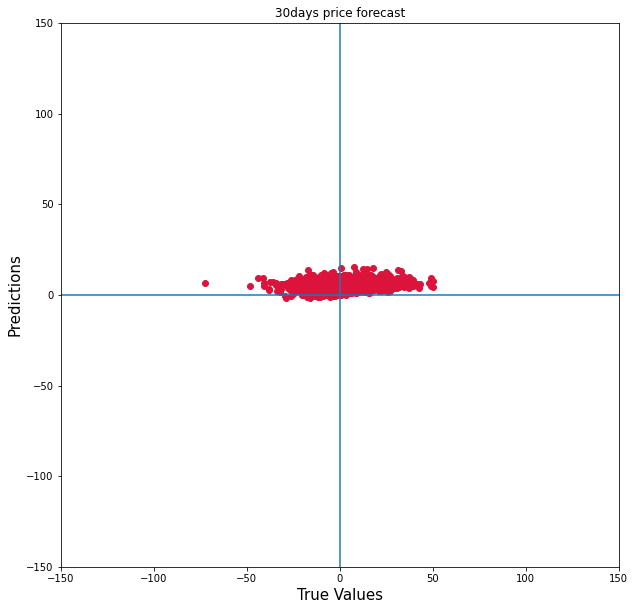

In [541]:
def true_predict_plot(y_val, ypred, title):
    plt.figure(figsize=(10,10))
    plt.scatter(y_val, ypred, c='crimson')
    plt.yscale('linear')
    plt.xscale('linear')

    p1 = max(max(ypred), max(y_val))
    p2 = min(min(ypred), min(y_val))
    #plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.ylim(-150, 150)
    plt.xlim(-150, 150)
    #plt.axis('equal')
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.title(title)
    plt.show()
    
true_predict_plot(y_test, ypred,'30days price forecast')

In [542]:
def accuracy_df(y_test, ypred):
    df_y_vals = pd.DataFrame()
    df_y_vals["Real"] = y_test
    df_y_vals["Prediction"] = ypred
    df_y_vals["Delta"] = df_y_vals["Real"] - df_y_vals["Prediction"]
    df_y_vals["Correct"] = 0
    df_y_vals.loc[((df_y_vals['Real'] >0) & (df_y_vals['Prediction'] >0)) | ((df_y_vals['Real'] <0) & (df_y_vals['Prediction'] <0)),'Correct'] = 1

    true_false_values = df_y_vals.groupby("Correct").count().Real.to_frame()

    true_false_values["Value, %"] = (true_false_values['Real'] / true_false_values['Real'].sum()) * 100
    true_false_values["Value, %"] = true_false_values["Value, %"].round(2)
    print(true_false_values)

    print("\nTotal cases evaluated:",true_false_values.Real.sum())
    return true_false_values

acc_percent_30d = accuracy_df(y_test, ypred)
acc_percent_30d = acc_percent_30d["Value, %"][1]

         Real  Value, %
Correct                
0        2382      43.0
1        3157      57.0

Total cases evaluated: 5539


We got 57% acuracy for the 500 companies. That is not bad. Let's check if we get better results with the other prediction periods.

### Let's see how we perform with the other forecast periods

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


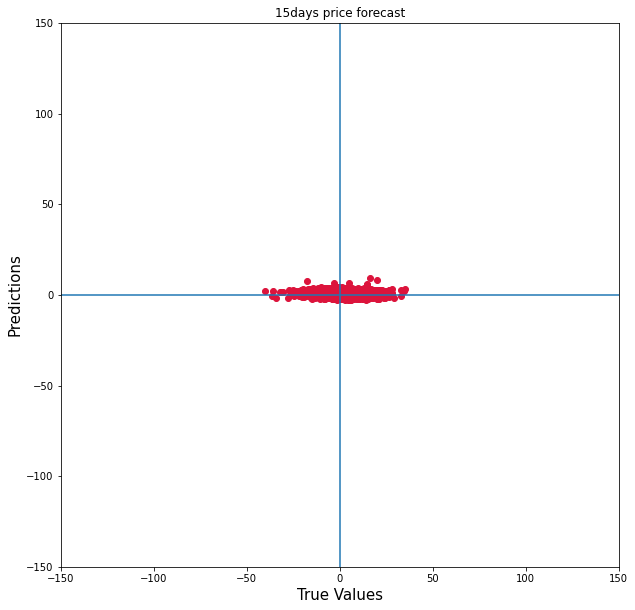

Accuracy of prediction:6.1166


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3814     58.31
1        2727     41.69

Total cases evaluated: 6541
    Value                     Feature   Value, %
37    214           days_after_crisis  14.266667
36    137                    VIX_high   9.133333
35    116                      sector   7.733333
34    103                    10YB_YoY   6.866667
33    102                     VIX_WoW   6.800000
32     96                     VIX_MoM   6.400000
31     69             10Y_Val_to_30MA   4.600000
30     67                     10YBond   4.466667
29     63            10Y_Val_to_200MA   4.200000
28     60           10YB_200MA_Vector   4.000000
27     59                    10YB_MoM   3.933333
26     40                     VIX_DoD   2.666667
25     39                          PE   2.600000
24     38                      YoY_DY   2.533333
23     34              EPS_YoY_Growth   2.266667
22     31        

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


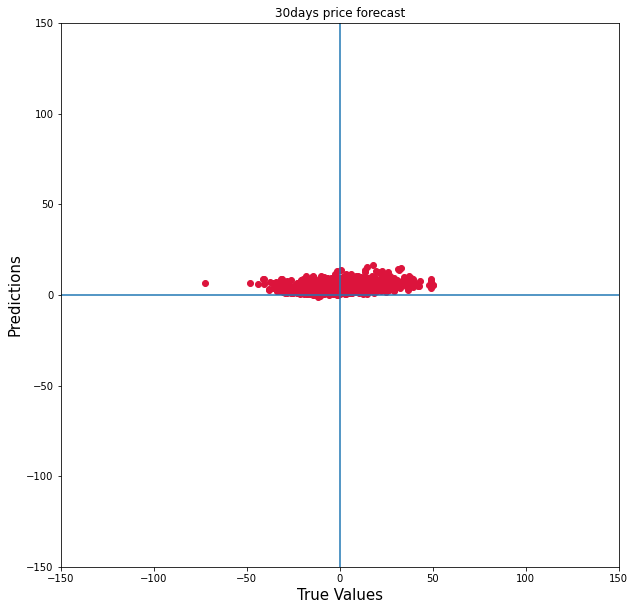

Accuracy of prediction:9.3239


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3304      50.9
1        3187      49.1

Total cases evaluated: 6491
    Value                     Feature   Value, %
37    228           days_after_crisis  15.200000
36    153                      sector  10.200000
35     97                    10YB_YoY   6.466667
34     95                    VIX_high   6.333333
33     69           10YB_200MA_Vector   4.600000
32     62                     VIX_MoM   4.133333
31     55                     10YBond   3.666667
30     52                      YoY_PE   3.466667
29     51             10Y_Val_to_30MA   3.400000
28     49            10Y_Val_to_200MA   3.266667
27     45              EPS_YoY_Growth   3.000000
26     44                      YoY_DY   2.933333
25     43                          PE   2.866667
24     38                          DY   2.533333
23     38                    10YB_MoM   2.533333
22     33        

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


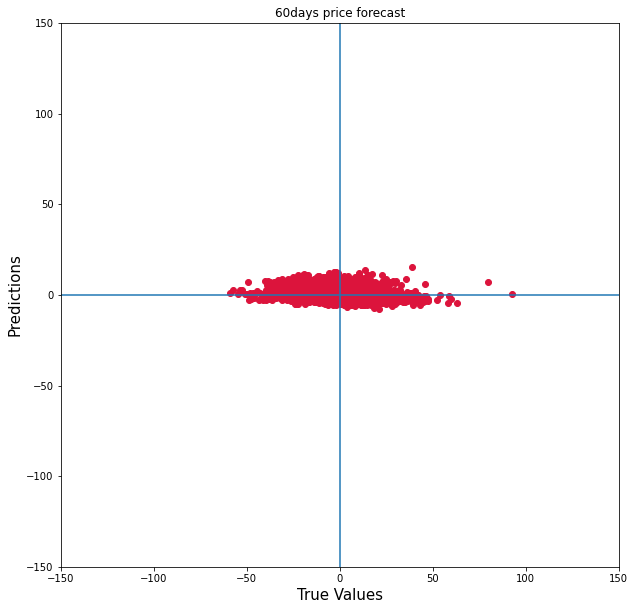

Accuracy of prediction:13.8357


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        4625     72.37
1        1766     27.63

Total cases evaluated: 6391
    Value                     Feature   Value, %
37    192           days_after_crisis  12.800000
36    171                      sector  11.400000
35     63           10YB_200MA_Vector   4.200000
34     58                    10YB_YoY   3.866667
33     56                    VIX_high   3.733333
32     54                          PE   3.600000
31     54                          DY   3.600000
30     54                     10YBond   3.600000
28     53                         ROE   3.533333
29     53                      YoY_DY   3.533333
27     52                          CR   3.466667
26     48                      YoY_PE   3.200000
25     45                          ES   3.000000
24     41           EPS_1Y_exp_Change   2.733333
23     40                EPS_surprise   2.666667
22     39       

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


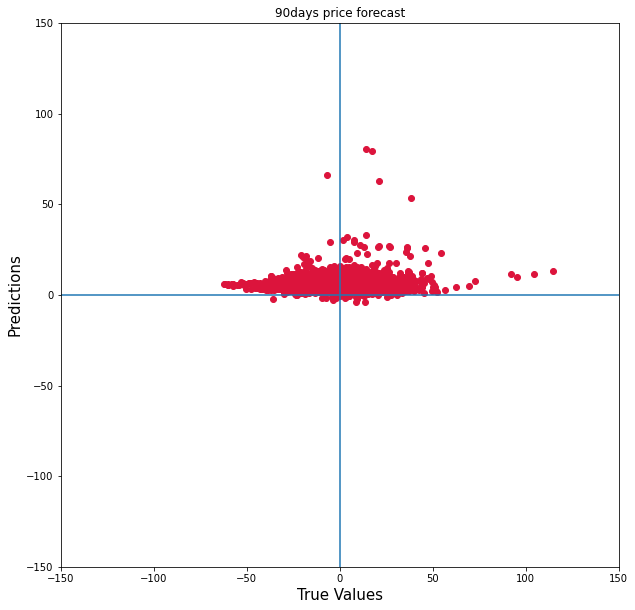

Accuracy of prediction:12.7986


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3417     54.32
1        2874     45.68

Total cases evaluated: 6291
    Value                     Feature   Value, %
37    202           days_after_crisis  13.466667
36    199                      sector  13.266667
35     72                          CR   4.800000
34     66           EPS_1Y_exp_Change   4.400000
33     65                          PE   4.333333
32     56                          DY   3.733333
31     55                    10YB_YoY   3.666667
30     52                      YoY_DY   3.466667
29     47                      YoY_CR   3.133333
28     44                          DE   2.933333
27     43                          ES   2.866667
26     42              EPS_YoY_Growth   2.800000
25     41                         ROE   2.733333
24     39                    VIX_high   2.600000
23     39                          GM   2.600000
22     38       

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


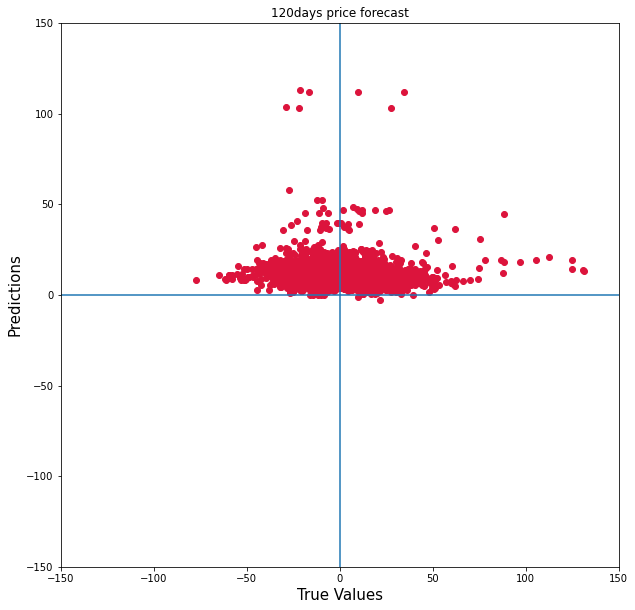

Accuracy of prediction:17.8491


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3447     55.68
1        2744     44.32

Total cases evaluated: 6191
    Value                     Feature   Value, %
37    196                      sector  13.066667
36    162           days_after_crisis  10.800000
35     82           EPS_1Y_exp_Change   5.466667
34     77                          DY   5.133333
33     62                          PE   4.133333
32     61                          CR   4.066667
31     57                          GM   3.800000
30     55                      YoY_DY   3.666667
29     51                          DE   3.400000
28     45              EPS_YoY_Growth   3.000000
27     43                      YoY_CR   2.866667
26     42                         ROE   2.800000
25     42            10Y_Val_to_200MA   2.800000
24     41          Acc_Rec_Pay_Ration   2.733333
23     39                          ES   2.600000
22     38       

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


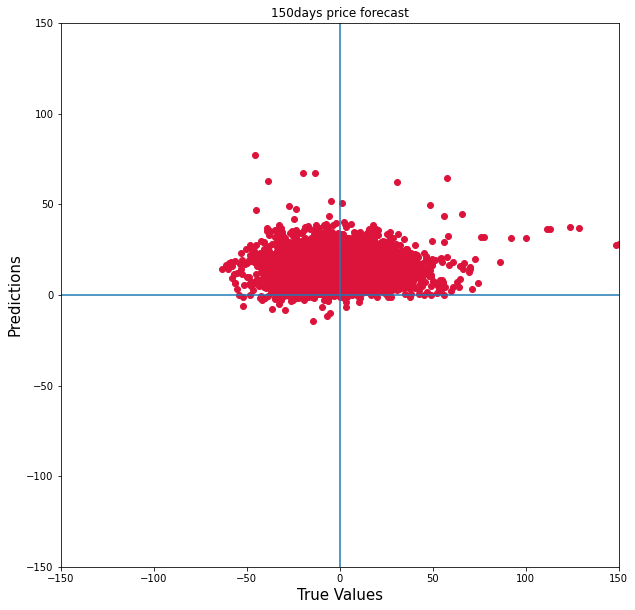

Accuracy of prediction:21.4898


Increase or decrease predicted correctly:
         Real  Value, %
Correct                
0        3440     56.48
1        2651     43.52

Total cases evaluated: 6091
    Value                     Feature   Value, %
37    198                      sector  13.200000
36    135           days_after_crisis   9.000000
35     92           EPS_1Y_exp_Change   6.133333
34     74                          DY   4.933333
33     63                          CR   4.200000
32     59                          DE   3.933333
31     56          Acc_Rec_Pay_Ration   3.733333
30     53              EPS_YoY_Growth   3.533333
29     52                          PE   3.466667
28     51                         ROE   3.400000
27     45                      YoY_DY   3.000000
26     45                    VIX_high   3.000000
25     45                          GM   3.000000
24     44                          ES   2.933333
23     42                      YoY_CR   2.800000
22     40       

In [543]:
targets_all =["future_15dprice_change","future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"]
periods = ["15days", "30days", "60days", "90days", "120days", "150days"]

MAEs = []
acc_percent_list = []
feature_importances = []
list_of_regression_models = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    
    df_train, df_test = train_dfs_list[j], test_dfs_list[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1).copy()
    df_test = df_test.drop(remove_redundant_list,axis = 1).copy()
    df_train = df_train[df_train[i].notna()]
    df_test = df_test[df_test[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)

    df_train.drop(["stock"], axis = 1, inplace = True)
    df_test.drop(["stock"], axis = 1, inplace = True)

    le = LabelEncoder()
    le.fit(df_train["sector"])
    df_train["sector"] = le.transform(df_train["sector"])
    df_test["sector"] = le.transform(df_test["sector"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMRegressor(random_state=42,n_jobs = 5, n_estimators = 50)
    list_of_regression_models.append(lgbm)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])

    #predicting on test set
    ypred=lgbm.predict(x_test)

    true_predict_plot(y_test, ypred, periods[j] +' price forecast')

    #calculating accuracy
    from sklearn.metrics import mean_absolute_error as mae
    accuracy = mae(y_test, ypred)
    MAEs.append(accuracy)
    print(f"Accuracy of prediction:{accuracy:0.4f}")

    print("\n\nIncrease or decrease predicted correctly:")
    acc_percent = accuracy_df(y_test, ypred)
    acc_percent = acc_percent["Value, %"][1]
    acc_percent_list.append(acc_percent)
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False))
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Result summarization

In [544]:
MAEs = [round(x*100,2) for x in MAEs]

index = [15,30,60,90,120,150]
accuracy_compare_dt = {"Absolute Error":MAEs,"Correctly Predicted Price Direction":acc_percent_list}
accuracy_compare_df= pd.DataFrame(accuracy_compare_dt, index=index)
accuracy_compare_df.index.name = "Forecasted Period, days"

print(accuracy_compare_df)

                         Absolute Error  Correctly Predicted Price Direction
Forecasted Period, days                                                     
15                               611.66                                41.69
30                               932.39                                49.10
60                              1383.57                                27.63
90                              1279.86                                45.68
120                             1784.91                                44.32
150                             2148.98                                43.52


We see that error is above 50% that states that the model performance is poor.

In [545]:
all_features_evolution = []
for i, j in enumerate(feature_importances):
    features_sorted = feature_importances[i].sort_values(by='Value, %', ascending=False)["Feature"].tolist()
    all_features_evolution.append(features_sorted)

features_evolution = pd.DataFrame(all_features_evolution, index = index)
accuracy_compare_df.index.name = "Forecasted Period, days"
features_evolution

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
15,days_after_crisis,VIX_high,sector,10YB_YoY,VIX_WoW,VIX_MoM,10Y_Val_to_30MA,10YBond,10Y_Val_to_200MA,10YB_200MA_Vector,...,YoY_GM,YoY_PEGF,YoY_PEGB,GM,DPR,PEG_Forward,Acc_Rec_Pay_Ration,YoY_ES,PEG_Backwards,Piotroski_Score
30,days_after_crisis,sector,10YB_YoY,VIX_high,10YB_200MA_Vector,VIX_MoM,10YBond,YoY_PE,10Y_Val_to_30MA,10Y_Val_to_200MA,...,YoY_Piotroski,YoY_PEGB,YoY_DPR,EPS_QoQ_frcst_diff,Acc_Rec_Pay_Ration,YoY_ES,DPR,PEG_Backwards,PEG_Forward,Piotroski_Score
60,days_after_crisis,sector,10YB_200MA_Vector,10YB_YoY,VIX_high,PE,DY,10YBond,ROE,YoY_DY,...,YoY_GM,YoY_Piotroski,PEG_Forward,10Y_Val_to_30MA,PEG_Backwards,10YB_MoM,EPS_QoQ_frcst_diff,days_after_earnings_report,VIX_DoD,Piotroski_Score
90,days_after_crisis,sector,CR,EPS_1Y_exp_Change,PE,DY,10YB_YoY,YoY_DY,YoY_CR,DE,...,YoY_Piotroski,PEG_Backwards,VIX_MoM,Piotroski_Score,10Y_Val_to_30MA,10YB_MoM,days_after_earnings_report,EPS_QoQ_frcst_diff,VIX_WoW,VIX_DoD
120,sector,days_after_crisis,EPS_1Y_exp_Change,DY,PE,CR,GM,YoY_DY,DE,EPS_YoY_Growth,...,VIX_MoM,Piotroski_Score,PEG_Backwards,YoY_PEGB,10YB_MoM,10Y_Val_to_30MA,days_after_earnings_report,VIX_WoW,EPS_QoQ_frcst_diff,VIX_DoD
150,sector,days_after_crisis,EPS_1Y_exp_Change,DY,CR,DE,Acc_Rec_Pay_Ration,EPS_YoY_Growth,PE,ROE,...,YoY_PEGB,PEG_Backwards,VIX_MoM,Piotroski_Score,10YB_MoM,EPS_QoQ_frcst_diff,10Y_Val_to_30MA,VIX_WoW,VIX_DoD,days_after_earnings_report


As we see our model finds external factors as bonds rate and fear level as the best predictors even for the long term forecast. 
Dividends change timing also play it's role as the industry compny works in.
My expectation was to see PE ratio in the top 5, but it seems it doesn't play a big role. 

## Changing the perspective

# ML Part Classification

### Building a classificator

Ok, we dealt with the numeric prediction of the stock prices movement.

At the same time after seeing the results it made me rethink the purpose.

I am not a trader and the model I am building doesn't have a purpose of daily stocks exchange.

What I want to achieve is to find a stock that with high probability will grow in the next foreseeable future, hold it for a while and sell it with a profit.

Considering this maybe we shouldn't solve the regression problem, but make it a classification problem instead.

To make it the classification problem we would need to replace all price times the prices are going up to 1 and down to zerows.

At the same time I want my model to cover the risks, so let's add the risk factor of loosing a bet and make the range wider.
We will change values to 1 when the price goes up on the level of 3rd percentile for every time range prediction

In [546]:
min_15d_threshold = 4.112
min_30d_threshold = 6.18
min_60d_threshold = 9.25
min_90d_threshold = 11.53
min_120d_threshold = 13.77
min_150d_threshold = 15.95

list_of_thresholds = [min_15d_threshold,min_30d_threshold,min_60d_threshold,min_90d_threshold,min_120d_threshold,min_150d_threshold]

Make the changes to the dataset

In [547]:
#df_compact_reserve = df_compact.copy()
#Creating a copy of the list with the dataframes
train_dfs_list_copy = []
test_dfs_list_copy = []
for i, j in enumerate(target_vars):
    train = train_dfs_list[i].copy()
    test = test_dfs_list[i].copy()
    train_dfs_list_copy.append(train)
    test_dfs_list_copy.append(test)

for i, j in enumerate(target_vars):
    #df_compact.loc[df_compact[j]<list_of_thresholds[i], j] = 0
    #df_compact.loc[df_compact[j]>=list_of_thresholds[i], j] = 1
    train_dfs_list_copy[i].loc[train_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    train_dfs_list_copy[i].loc[train_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1
    test_dfs_list_copy[i].loc[test_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    test_dfs_list_copy[i].loc[test_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1

In [639]:
np.random.randint(0, 2, 12)


array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0])

#### Let's build a model for the 30 days prediction and then do the same for the rest of time frames

Precision of prediction:0.50, and the AUC is: 0.71


<AxesSubplot:>

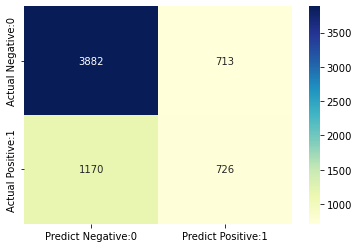

In [653]:
#df_compact_temp = df_compact.drop(["future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
#df_compact_temp = df_compact_temp[df_compact_temp["future_15dprice_change"].notna()]
#df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
df_train, df_test = train_dfs_list_copy[1], test_dfs_list_copy[1]
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_train = df_train[df_train["future_30dprice_change"].notna()]
df_test = df_test.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_test = df_test[df_test["future_30dprice_change"].notna()]

df_train.drop(["stock"], axis = 1, inplace = True)
df_test.drop(["stock"], axis = 1, inplace = True)

le = LabelEncoder()
le.fit(df_train["sector"])
df_train["sector"] = le.transform(df_train["sector"])
df_test["sector"] = le.transform(df_test["sector"])

#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)

lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


## Cross validation time data

In [654]:
df_train.sort_index(ascending = False, inplace = True)
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)

display(df_train.head(2))
df_train.shape

,days_after_earnings_report,sector,ROE,DE,CR,GM,DPR,Acc_Rec_Pay_Ration,ES,DY,...,VIX_DoD,VIX_WoW,VIX_MoM,10YBond,10YB_MoM,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,YoY_DY
0,48.0,6,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.972044,3.058483,...,-0.385888,43.412698,48.479869,1.703,8.058376,-26.052974,-0.015955,5.748679,0.647387,109.690527
1,55.0,6,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.957344,3.012228,...,-14.440895,-25.899281,2.841782,1.632,5.086929,-23.880597,-0.073181,-0.042892,-3.330576,138.288908


(121294, 39)

In [661]:
y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)

tscv = TimeSeriesSplit(n_splits=10, test_size=6000, gap=round(4.4*502,0))

aucs = []
precs = []

for i, (train_index, val_idx) in enumerate(tscv.split(df_train)):
        print(f"======= Fold {i} ========")
        print(f"  Train: index={min(train_index)} : {max(train_index)}")
        print(f"  Test:  index={min(val_idx)} : {max(val_idx)}")

        X_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]

        X_val = x_train.loc[val_idx]
        y_val = y_train.loc[val_idx] 

        # Fit Model on Train
        clf = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        print(pred.sum())
        if pred.sum() == 0:
            
        pred_prob = clf.predict_proba(X_val)[:, 1]
        acc_score = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred, pos_label=1, average='binary')
        auc_score = roc_auc_score(y_val, pred_prob)
        
        print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {precision:0.4f}, and AUC is {auc_score:0.4f}"
        )
        aucs.append(auc_score)
        oof_auc = np.mean(aucs)
        precs.append(precision)
        precs_auc = np.mean(precs)
        print(f'Our out of fold AUC score is {oof_auc:0.4f} and precision is {precs_auc:0.4f} \n\n')

======= Fold 0 ========
  Train: index=0 : 59293
  Test:  index=61294 : 67293
2228.0
Our accuracy on the validation set is 0.8015, precision is 0.6382, and AUC is 0.8308
Our out of fold AUC score is 0.8308 and precision is 0.6382 


======= Fold 1 ========
  Train: index=0 : 65293
  Test:  index=67294 : 73293
1400.0
Our accuracy on the validation set is 0.5620, precision is 0.4286, and AUC is 0.5563
Our out of fold AUC score is 0.6936 and precision is 0.5334 


======= Fold 2 ========
  Train: index=0 : 71293
  Test:  index=73294 : 79293
97.0
Our accuracy on the validation set is 0.7270, precision is 0.4845, and AUC is 0.5774
Our out of fold AUC score is 0.6548 and precision is 0.5171 


======= Fold 3 ========
  Train: index=0 : 77293
  Test:  index=79294 : 85293
0.0
Our accuracy on the validation set is 0.6295, precision is 0.0000, and AUC is 0.5761
Our out of fold AUC score is 0.6352 and precision is 0.3878 


======= Fold 4 ========
  Train: index=0 : 83293
  Test:  index=85294 : 9

In [ ]:
#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)



lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### We got increase of precision from 49% in the regression model to 50% in classification model.
I know that we are kind of comparing apples to oranges, but with a target we have in mind this is a great result without model tuning and little efforts.

#### Let's find the best timeframe to invest testing the classification for all the prediction length

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 15days:0.38

AUC of this classifier for 15days:0.63


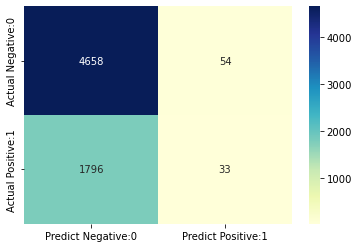

    Value            Feature   Value, %
37    230  days_after_crisis  15.333333
36    122           VIX_high   8.133333
35    115             sector   7.666667
34    113           10YB_YoY   7.533333
33    102  10YB_200MA_Vector   6.800000
32     86            VIX_MoM   5.733333
31     84            10YBond   5.600000
30     76   10Y_Val_to_200MA   5.066667
29     69    10Y_Val_to_30MA   4.600000
28     67            VIX_WoW   4.466667


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 30days:0.50

AUC of this classifier for 30days:0.71


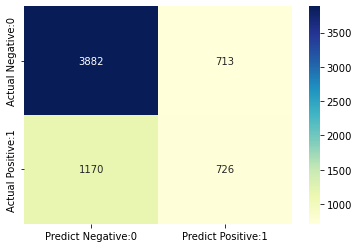

    Value                     Feature   Value, %
37    258           days_after_crisis  17.200000
36    168                      sector  11.200000
35    108                    10YB_YoY   7.200000
34     90                    VIX_high   6.000000
33     79           10YB_200MA_Vector   5.266667
32     57                     10YBond   3.800000
31     56                          PE   3.733333
30     48  days_after_earnings_report   3.200000
28     44                    10YB_MoM   2.933333
29     44            10Y_Val_to_200MA   2.933333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 60days:0.10

AUC of this classifier for 60days:0.23


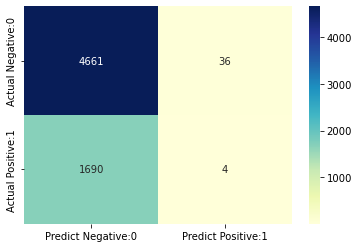

    Value            Feature   Value, %
37    206  days_after_crisis  13.733333
36    171             sector  11.400000
35     74           10YB_YoY   4.933333
34     69            10YBond   4.600000
33     61           VIX_high   4.066667
32     60  10YB_200MA_Vector   4.000000
31     53                 CR   3.533333
30     52                 PE   3.466667
29     51                 DE   3.400000
28     44                ROE   2.933333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 90days:0.31

AUC of this classifier for 90days:0.55


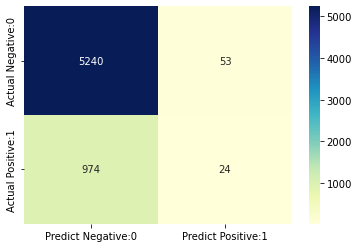

    Value             Feature   Value, %
37    232   days_after_crisis  15.466667
36    166              sector  11.066667
35     77                  DE   5.133333
34     59            10YB_YoY   3.933333
33     58                  CR   3.866667
32     54  Acc_Rec_Pay_Ration   3.600000
31     53                 ROE   3.533333
30     50                  PE   3.333333
29     50                  DY   3.333333
28     44                  GM   2.933333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 120days:0.11

AUC of this classifier for 120days:0.46


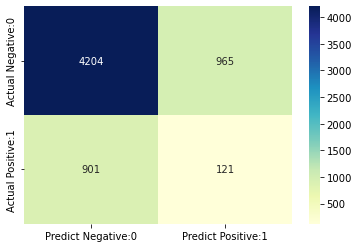

    Value             Feature   Value, %
37    186   days_after_crisis  12.400000
36    174              sector  11.600000
35     80                  DE   5.333333
34     65  Acc_Rec_Pay_Ration   4.333333
33     58                 ROE   3.866667
32     53   EPS_1Y_exp_Change   3.533333
31     51                  CR   3.400000
30     50                  DY   3.333333
29     48         PEG_Forward   3.200000
28     47              YoY_GM   3.133333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 150days:0.14

AUC of this classifier for 150days:0.53


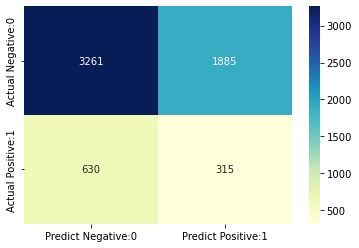

    Value             Feature   Value, %
37    174              sector  11.600000
36    162   days_after_crisis  10.800000
35     77                  DE   5.133333
34     66  Acc_Rec_Pay_Ration   4.400000
33     62                  CR   4.133333
32     61                  DY   4.066667
31     58   EPS_1Y_exp_Change   3.866667
30     56              YoY_GM   3.733333
29     54      EPS_YoY_Growth   3.600000
28     52            VIX_high   3.466667


In [550]:
precisions_list = []
AUC_list = []
feature_importances = []
list_of_classification_models = []
list_of_test_df = []
list_of_ypred = []
list_of_ypred_proba = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
    df_train, df_test = train_dfs_list_copy[j], test_dfs_list_copy[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1)
    df_train = df_train[df_train[i].notna()]
    df_test = df_test.drop(remove_redundant_list,axis = 1)
    df_test = df_test[df_test[i].notna()]

    df_train.drop(["stock"], axis = 1, inplace = True)
    df_test.drop(["stock"], axis = 1, inplace = True)
    list_of_test_df.append(df_test)

    le = LabelEncoder()
    le.fit(df_train["sector"])
    df_train["sector"] = le.transform(df_train["sector"])
    df_test["sector"] = le.transform(df_test["sector"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    list_of_classification_models.append(lgbm)

    #predicting on test set
    ypred=lgbm.predict(x_test)
    ypred_prob = lgbm.predict_proba(x_test)[:, 1]
    list_of_ypred.append(ypred)
    list_of_ypred_proba.append(ypred_prob)

    #calculating accuracy
    precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
    AUC = round(roc_auc_score(y_test, ypred_prob),2)
    print("\n"*3+"="*50+"\n"+f"Precision of prediction for {periods[j]}:{precision:0.2f}")
    print("\n"+f"AUC of this classifier for {periods[j]}:{AUC:0.2f}")
    precisions_list.append(precision)
    AUC_list.append(AUC)

    cm = confusion_matrix(y_test, ypred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                     index=['Actual Negative:0', 'Actual Positive:1'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False)[:10])
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Let's summarize the precision level we got for every record

In [551]:
precisions_list = [round(x*100,2) for x in precisions_list]
AUC_list = [round(x*100,2) for x in AUC_list]

precisions_compare_dt = {"Precision achieved":precisions_list,"AUC achieved":AUC_list}
precisions_compare_df= pd.DataFrame(precisions_compare_dt, index=index)
precisions_compare_df.index.name = "Forecasted Period, days"

print(precisions_compare_df)

                         Precision achieved  AUC achieved
Forecasted Period, days                                  
15                                     38.0          63.0
30                                     50.0          71.0
60                                     10.0          23.0
90                                     31.0          55.0
120                                    11.0          46.0
150                                    14.0          53.0


The max precision we achieved is for 30days prediction timeframe and it's 50%.

We also need to remember that to be secure we are not predictiong when the price goes up, but when it goes up for more than 6% in case of 30 days and 4.1% in case of 15 days prediction.

I trully wonder what might be the total precision if we compare it with the zero level.
We have indexes untouched so lets compare.

In [556]:
# first let's create a new column with the 30days prediction classifier: 0 when price dropped and 1 when it's increased.
df_30d_train = train_dfs_list[1]
df_30d_test = test_dfs_list[1]

df_30d_train.loc[df_30d_train["future_30dprice_change"]<0.1, "30dprice_change_classification"] = 0
df_30d_train.loc[df_30d_train["future_30dprice_change"]>=0.1, "30dprice_change_classification"] = 1
df_30d_test.loc[df_30d_test["future_30dprice_change"]<0.1, "30dprice_change_classification"] = 0
df_30d_test.loc[df_30d_test["future_30dprice_change"]>=0.1, "30dprice_change_classification"] = 1

In [566]:
print(df_30d_test.shape)
len(list_of_ypred[1])

(6491, 46)


6491

In [567]:
#let's join prediction result to the test dataframe and get indexes
df_prediction = df_30d_test.copy()
df_prediction["prediction"] = list_of_ypred[1]
df_prediction = df_prediction["prediction"]

In [568]:
#let's connect prediction result by indexes to the main dataframe
df_30_compare =  df_30d_test[["future_30dprice_change","30dprice_change_classification"]]
df_30_compare = df_30_compare.join(df_prediction, how = 'left')
df_30_compare = df_30_compare[df_30_compare["prediction"].notnull()]

In [569]:
# Now let's see how many negative values were really predicted as positive
df_30_compare = df_30_compare[["30dprice_change_classification","prediction"]].groupby("30dprice_change_classification").sum()
df_30_compare["Value, %"] = (df_30_compare['prediction'] / df_30_compare['prediction'].sum()) * 100
df_30_compare

,prediction,"Value, %"
30dprice_change_classification,,
0.0,442.0,30.715775
1.0,997.0,69.284225


## 69% PRECISION!!!!!

This is a great result so far. 

Let's check if we can make it higher playing with the LightGBM probability

In [609]:
df_30_compare =  df_30d_test[["30dprice_change_classification"]]
df_30_compare["proba"] = list_of_ypred_proba[1]
display(df_30_compare.head(5))

,30dprice_change_classification,proba
2002,1.0,0.212079
2003,0.0,0.340736
2004,1.0,0.337511
2005,1.0,0.237776
2006,1.0,0.289579


In [612]:
threshold = [0.5,0.55,0.6,0.65]
for i in threshold:
    df_30_compare.loc[df_30_compare["proba"]<i, "class_calc"] = 0
    df_30_compare.loc[df_30_compare["proba"]>=i, "class_calc"] = 1
    
    df_new = df_30_compare[["30dprice_change_classification","class_calc"]].groupby("30dprice_change_classification").sum()
    df_new["Value, %"] = (df_new['class_calc'] / df_new['class_calc'].sum()) * 100
    display(df_new)

,class_calc,"Value, %"
30dprice_change_classification,,
0.0,442,30.715775
1.0,997,69.284225


,class_calc,"Value, %"
30dprice_change_classification,,
0.0,195,29.061103
1.0,476,70.938897


,class_calc,"Value, %"
30dprice_change_classification,,
0.0,57,35.403727
1.0,104,64.596273


,class_calc,"Value, %"
30dprice_change_classification,,
0.0,5,38.461538
1.0,8,61.538462


We achieved the maximum precision of 70.9% with the increased probability threshold to 55%

# Real Data Validation

In [615]:
max_date = df_compact.date.max()

I've uploaded the latest SP500 data. Let's read it

In [619]:
#os.chdir("/Users/olegkazanskyi/Documents/GitHub/Trading/CSVs")
os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python/SP500_CSVs_01032023")
filepaths = [f for f in os.listdir("./") if f.endswith('.csv')]
df_val = pd.DataFrame()
for i in filepaths:
    iterate_df = pd.DataFrame()
    iterate_df = pd.read_csv(i, encoding= 'unicode_escape')
    iterate_df["stock"] = i[:-4]
    df_val = pd.concat([df_val,iterate_df])
#df = pd.concat(map(pd.read_csv, filepaths))

#os.chdir("/Users/olegkazanskyi/Documents/GitHub/Trading")
os.chdir("C:/Users/oleg.kazanskyi/Personal-oleg.kazanskyi/Trading Python")

Let's keep only the latest date we need for validation

In [635]:
df_validation = df_val[df_val.date > max_date]

Let's change the dataset with the same steps we used in this project:

In [636]:
df_validation = df_validation[df_validation.EPS_surprise.notnull()]

df_validation['DY'].fillna(0, inplace=True)
df_validation['YoY_DPR'].fillna(0, inplace=True)
df_validation['DPR'].fillna(0, inplace=True)
df_validation['YoY_DY'].fillna(0, inplace=True)     

df_validation = df_validation[df_validation.YoY_CR.notnull()]

df_validation['DE'].fillna(0, inplace=True)
df_validation['LTDE'].fillna(0, inplace=True)

df_validation = df_validation[df_validation.VIX_MoM.notnull()]

df_validation['Acc_Rec_Pay_Ration'].fillna(0, inplace=True)

df_validation = df_validation[df_validation.PEG_Backwards.notnull()]

df_validation = df_validation[df_validation.EPS_1Y_exp_Change.notnull()]

df_validation.loc[df_validation['stock'] == 'GEN','sector'] = 'Information Technology'
df_validation.loc[df_validation['stock'] == 'GEN','industry'] = 'Software & Services'

df_validation = df_validation[df_validation.YoY_AR_Ration.notnull()]

df_validation.drop(["industry"], axis = 1, inplace = True)

df_validation.replace([np.inf, -np.inf], np.nan, inplace = True)

df_validation = df_validation[df_validation.EPS_1Y_exp_Change.notnull() & df_validation.EPS_YoY_Growth.notnull() & df_validation.EPS_QoQ_frcst_diff.notnull()]

df_validation = df_validation.iloc[::5, :]

df_validation.drop(['open',
                 'close',
                 'ROA', 
                 'YoY_ROE',
                 'YoY_ROA',
                 'LTDE', 
                 'PB', 
                 'YoY_LTDE', 
                 'YoY_DE', 
                 'YoY_PB', 
                 'YoY_AR_Ration', 
                 '10YB_30MA_Vector'], axis = 1, inplace = True)

df_validation.sort_values('date', ascending = False, inplace = True)

df_validation.reset_index(inplace = True)
df_validation.drop('index', axis = 1, inplace = True)

df_validation.drop('date',axis = 1, inplace = True)

df_validation.drop('stock', axis = 1, inplace = True)

Let's label encode the sector to numeric values suitable for the LightGBM

In [622]:
df_validation["sector"] = le.transform(df_validation["sector"])

We are testing only 30 days forecast.
We can drop other target variables

In [625]:
df_validation.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"], axis = 1, inplace = True)

In [630]:
df_validation = df_validation[df_validation.future_30dprice_change.notnull()]

In [632]:
lgbm = list_of_classification_models[1]

y_test = df_validation["future_30dprice_change"]
x_test = df_validation.drop('future_30dprice_change', axis = 1)

In [634]:
y_test

Series([], Name: future_30dprice_change, dtype: float64)

We can run the test of the ML model now

In [631]:
#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]
list_of_ypred.append(ypred)
list_of_ypred_proba.append(ypred_prob)

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print("\n"*3+"="*50+"\n"+f"Precision of prediction for {periods[j]}:{precision:0.2f}")
print("\n"+f"AUC of this classifier for {periods[j]}:{AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
print(feature_imp.sort_values(by='Value, %', ascending=False)[:10])
feature_importances.append(feature_imp[["Feature", "Value, %"]])

ValueError: Input data must be 2 dimensional and non empty.

# Final Word

On average with every winning bet we can get about 5.8% of stock value. If it is true, it's an amazing result for 14 days trade.

We see that some bets lead to loss of  15.5%, at the same time max gain of the win bet is 33%.

Overall the results looks promising, and the level of precision is way higher than I expected after testing the model on validation.

I really would like to go live with the model.

### Save the model as joblib

In [ ]:
#Saving the label encoder
filename = 'C:\\Users\\oleg.kazanskyi\\OneDrive - Danaher\\Documents\\Trading Python\\Models\\label_encoder_012023.joblib'
joblib.dump(le, filename)

In [ ]:
#Saving the models
for i, period in enumerate(periods):
    folder = 'C:\\Users\\oleg.kazanskyi\\OneDrive - Danaher\\Documents\\Trading Python\\Models\\'
    full_path = os.path.join(folder,period+"_model.joblib")
    joblib.dump(list_of_classification_models[i], full_path)